## 6.1 모형 진단과 수정

회귀분석 결과의 진단(diagnosis)이란 회귀분석에 사용된 데이터가 회귀분석에 사용된 모형 가정을 제대로 만족하고 있는지를 확인하는 과정이다. 

## 잔차 정규성

데이터가 모형 가정을 만족하면 분석결과로 나온 잔차는 정규분포를 따라야 한다. 예를 들어 다음과 같이 2차 비선형 관계를 가지는 데이터를 선형 모형으로 회귀 분석한 경우를 살펴보자.

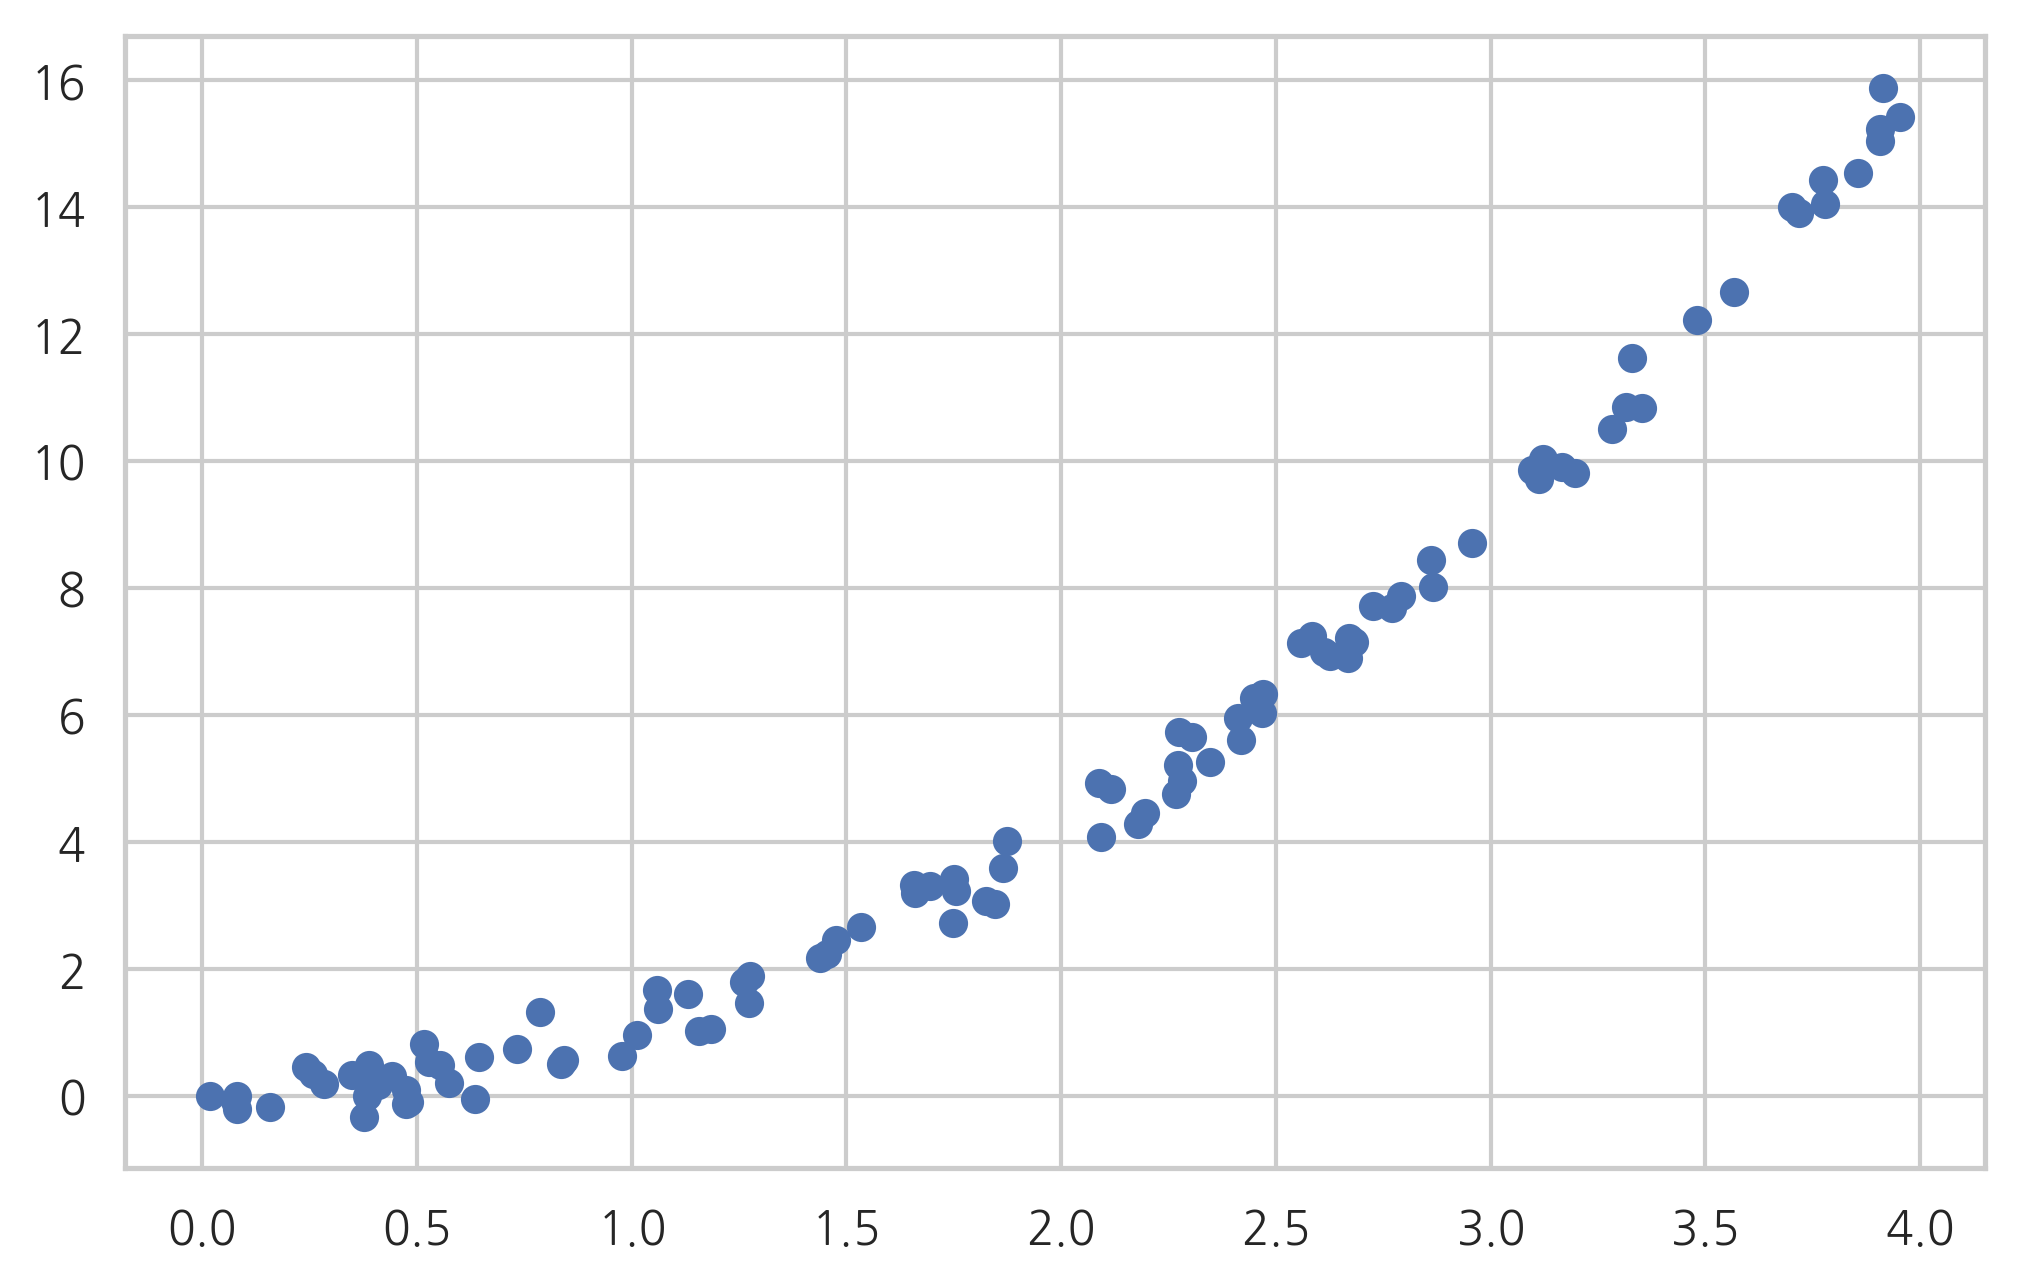

In [1]:
def make_regression2(n_sample=100, bias=0, noise=0.3, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 4
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x2, y2 = make_regression2()
plt.scatter(x2, y2)
plt.show()

In [2]:
dfX20 = pd.DataFrame(x2, columns=["X1"])
dfX2 = sm.add_constant(dfX20)
dfy2 = pd.DataFrame(y2, columns=["y"])

model2 = sm.OLS(dfy2, dfX2)
result2 = model2.fit()

QQ플롯과 정규성 검정에서 보듯이 잔차는 정규 분포를 따르지 않는다.

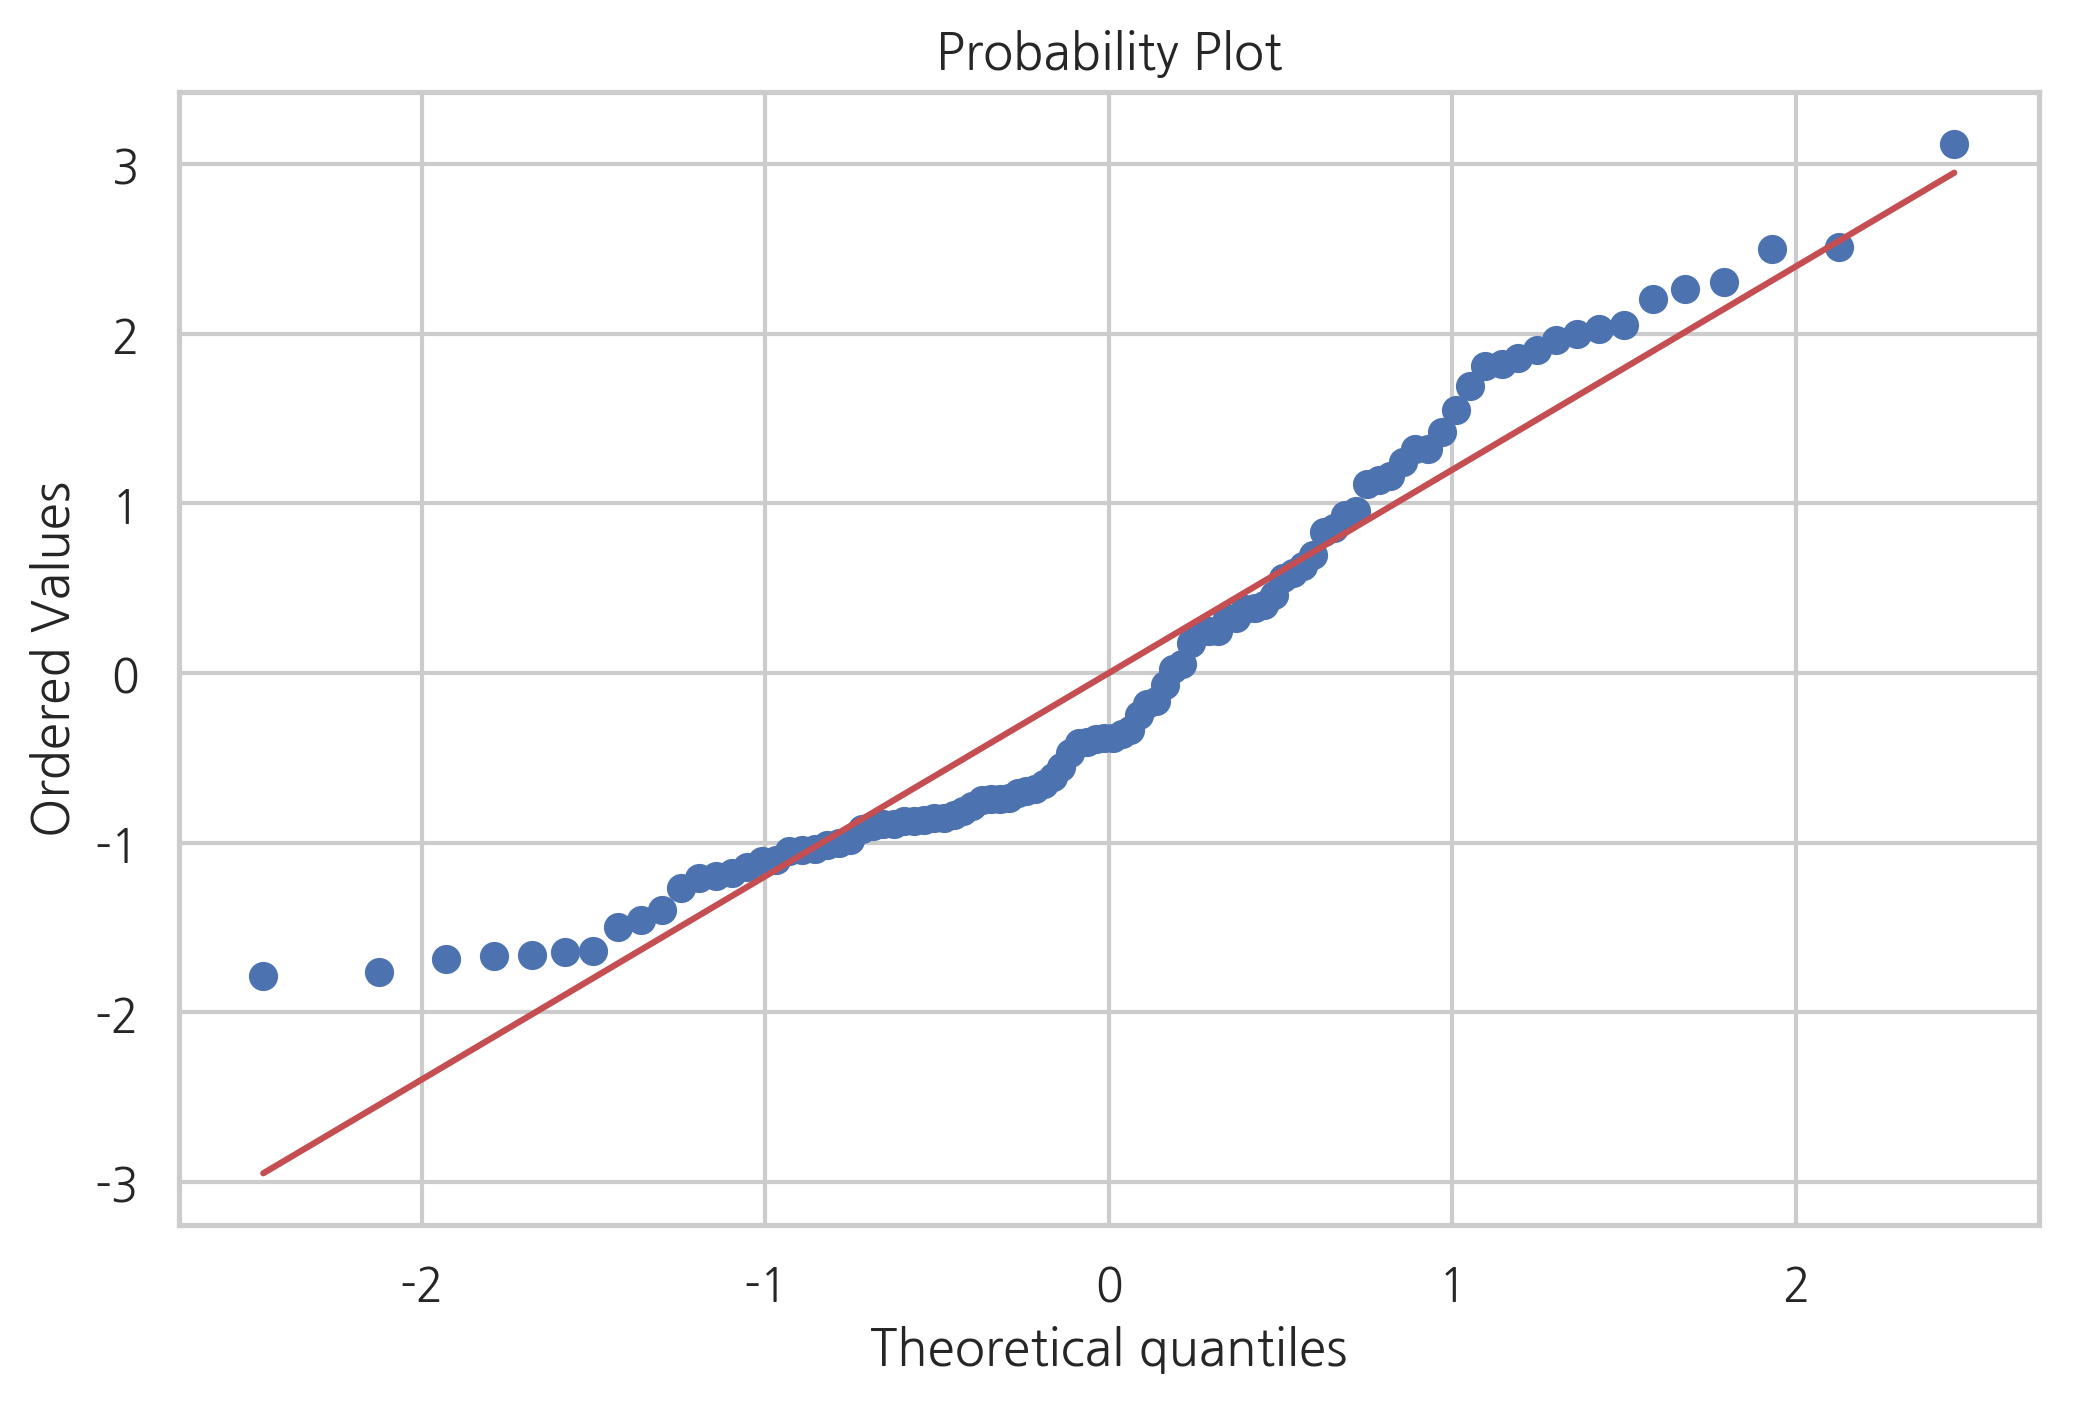

In [3]:
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [4]:
test = sm.stats.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  9.520
P-value     :  0.009


## 잔차와 독립 변수의 관계

이번에는 또다른 데이터를 살펴보자. 이 데이터도 2차 함수 관계를 따르고 있으므로 선형 모형을 따르지 않는다.

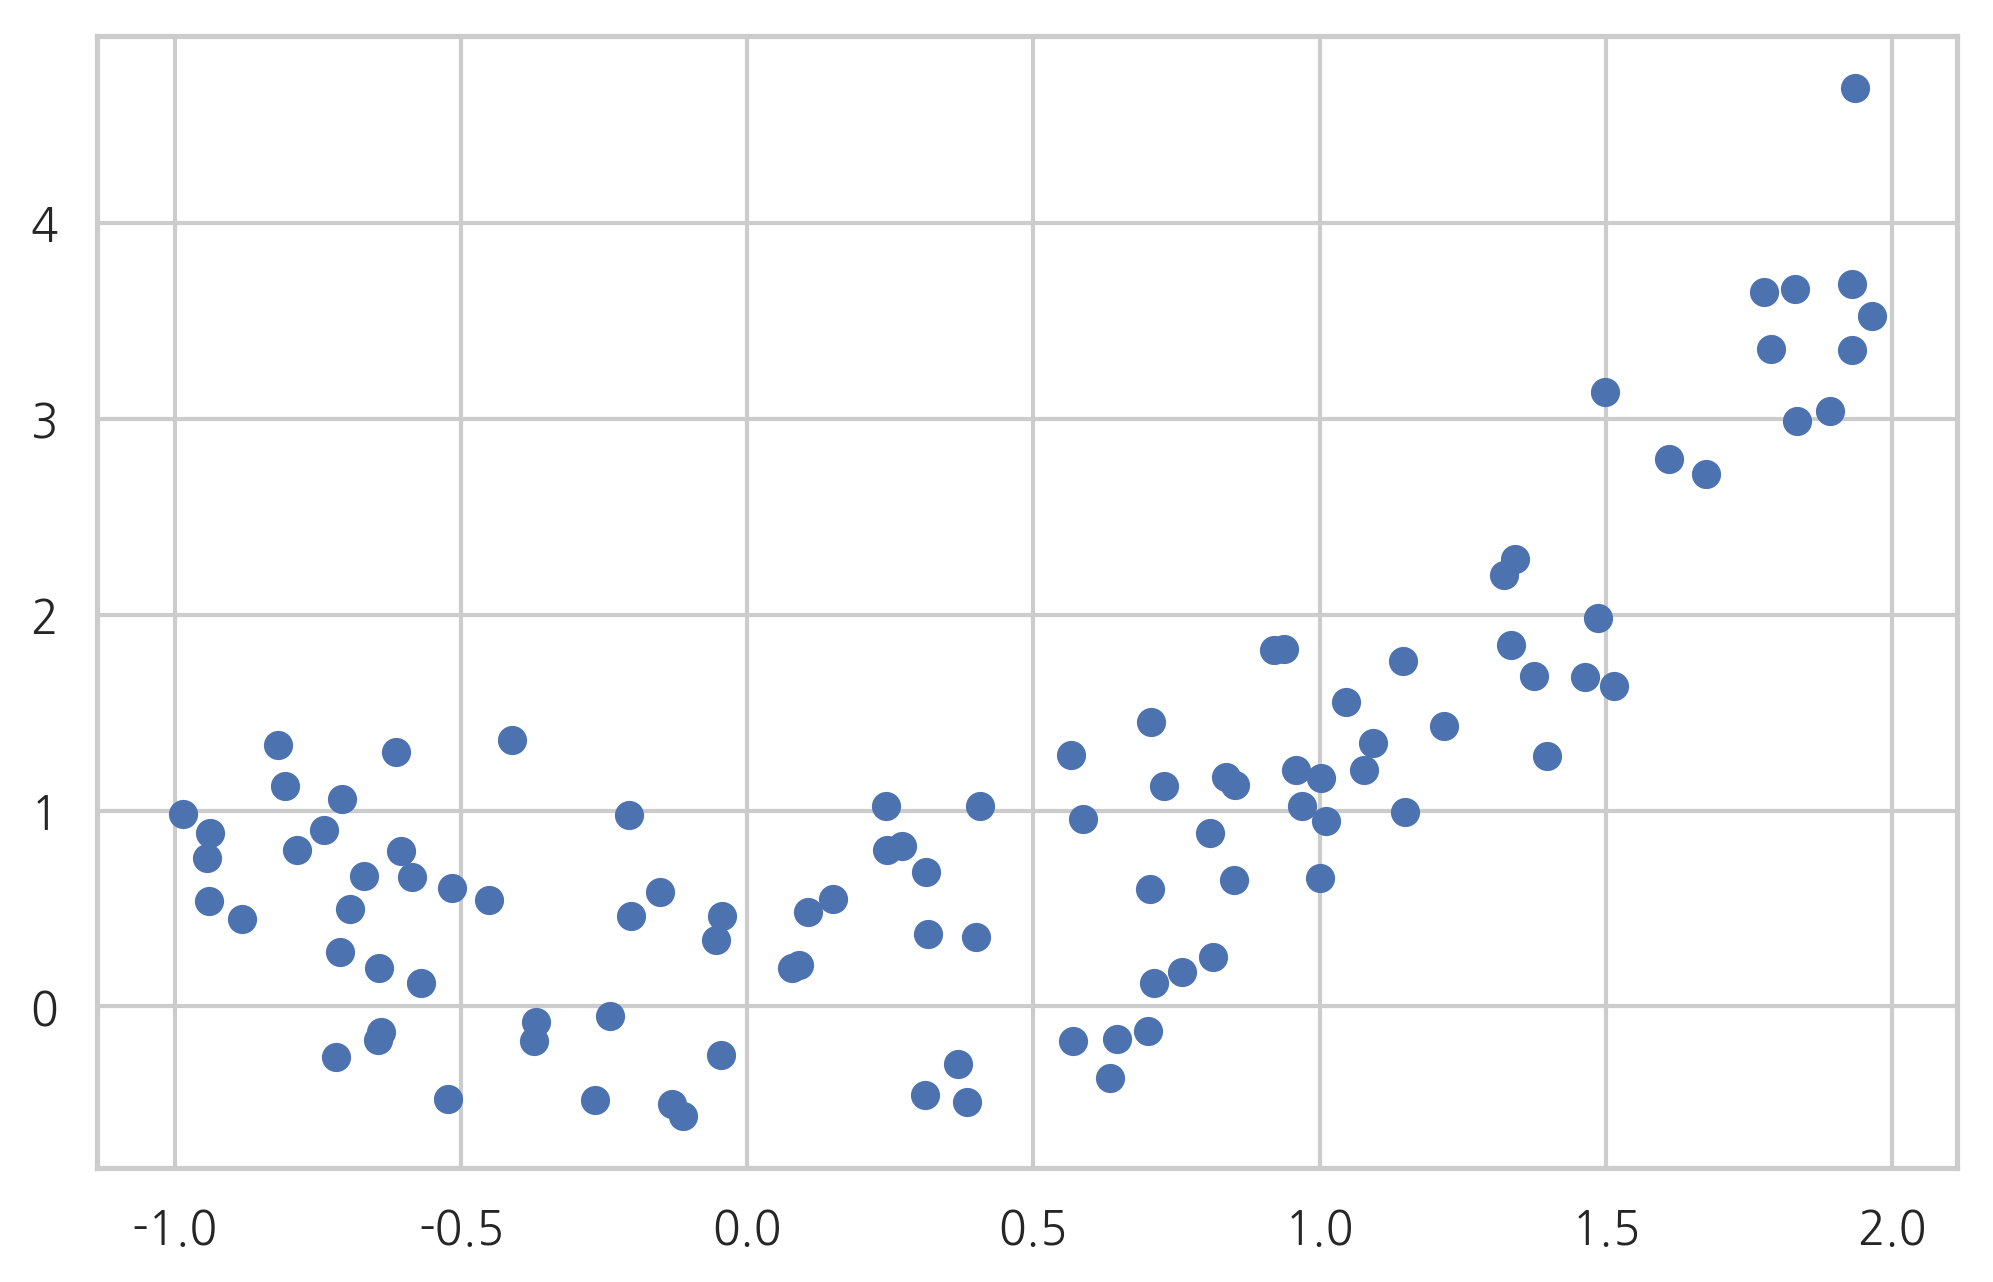

In [5]:
def make_regression3(n_sample=100, bias=0, noise=0.5, random_state=0):
    np.random.seed(random_state)
    x = np.random.rand(n_sample) * 3 - 1
    epsilon = noise * np.random.randn(n_sample)
    y = x ** 2 + bias + epsilon
    return x, y


x3, y3 = make_regression3()
plt.scatter(x3, y3)
plt.show()

In [6]:
dfX30 = pd.DataFrame(x3, columns=["X1"])
dfX3 = sm.add_constant(dfX30)
dfy3 = pd.DataFrame(y3, columns=["y"])

model3 = sm.OLS(dfy3, dfX3)
result3 = model3.fit()

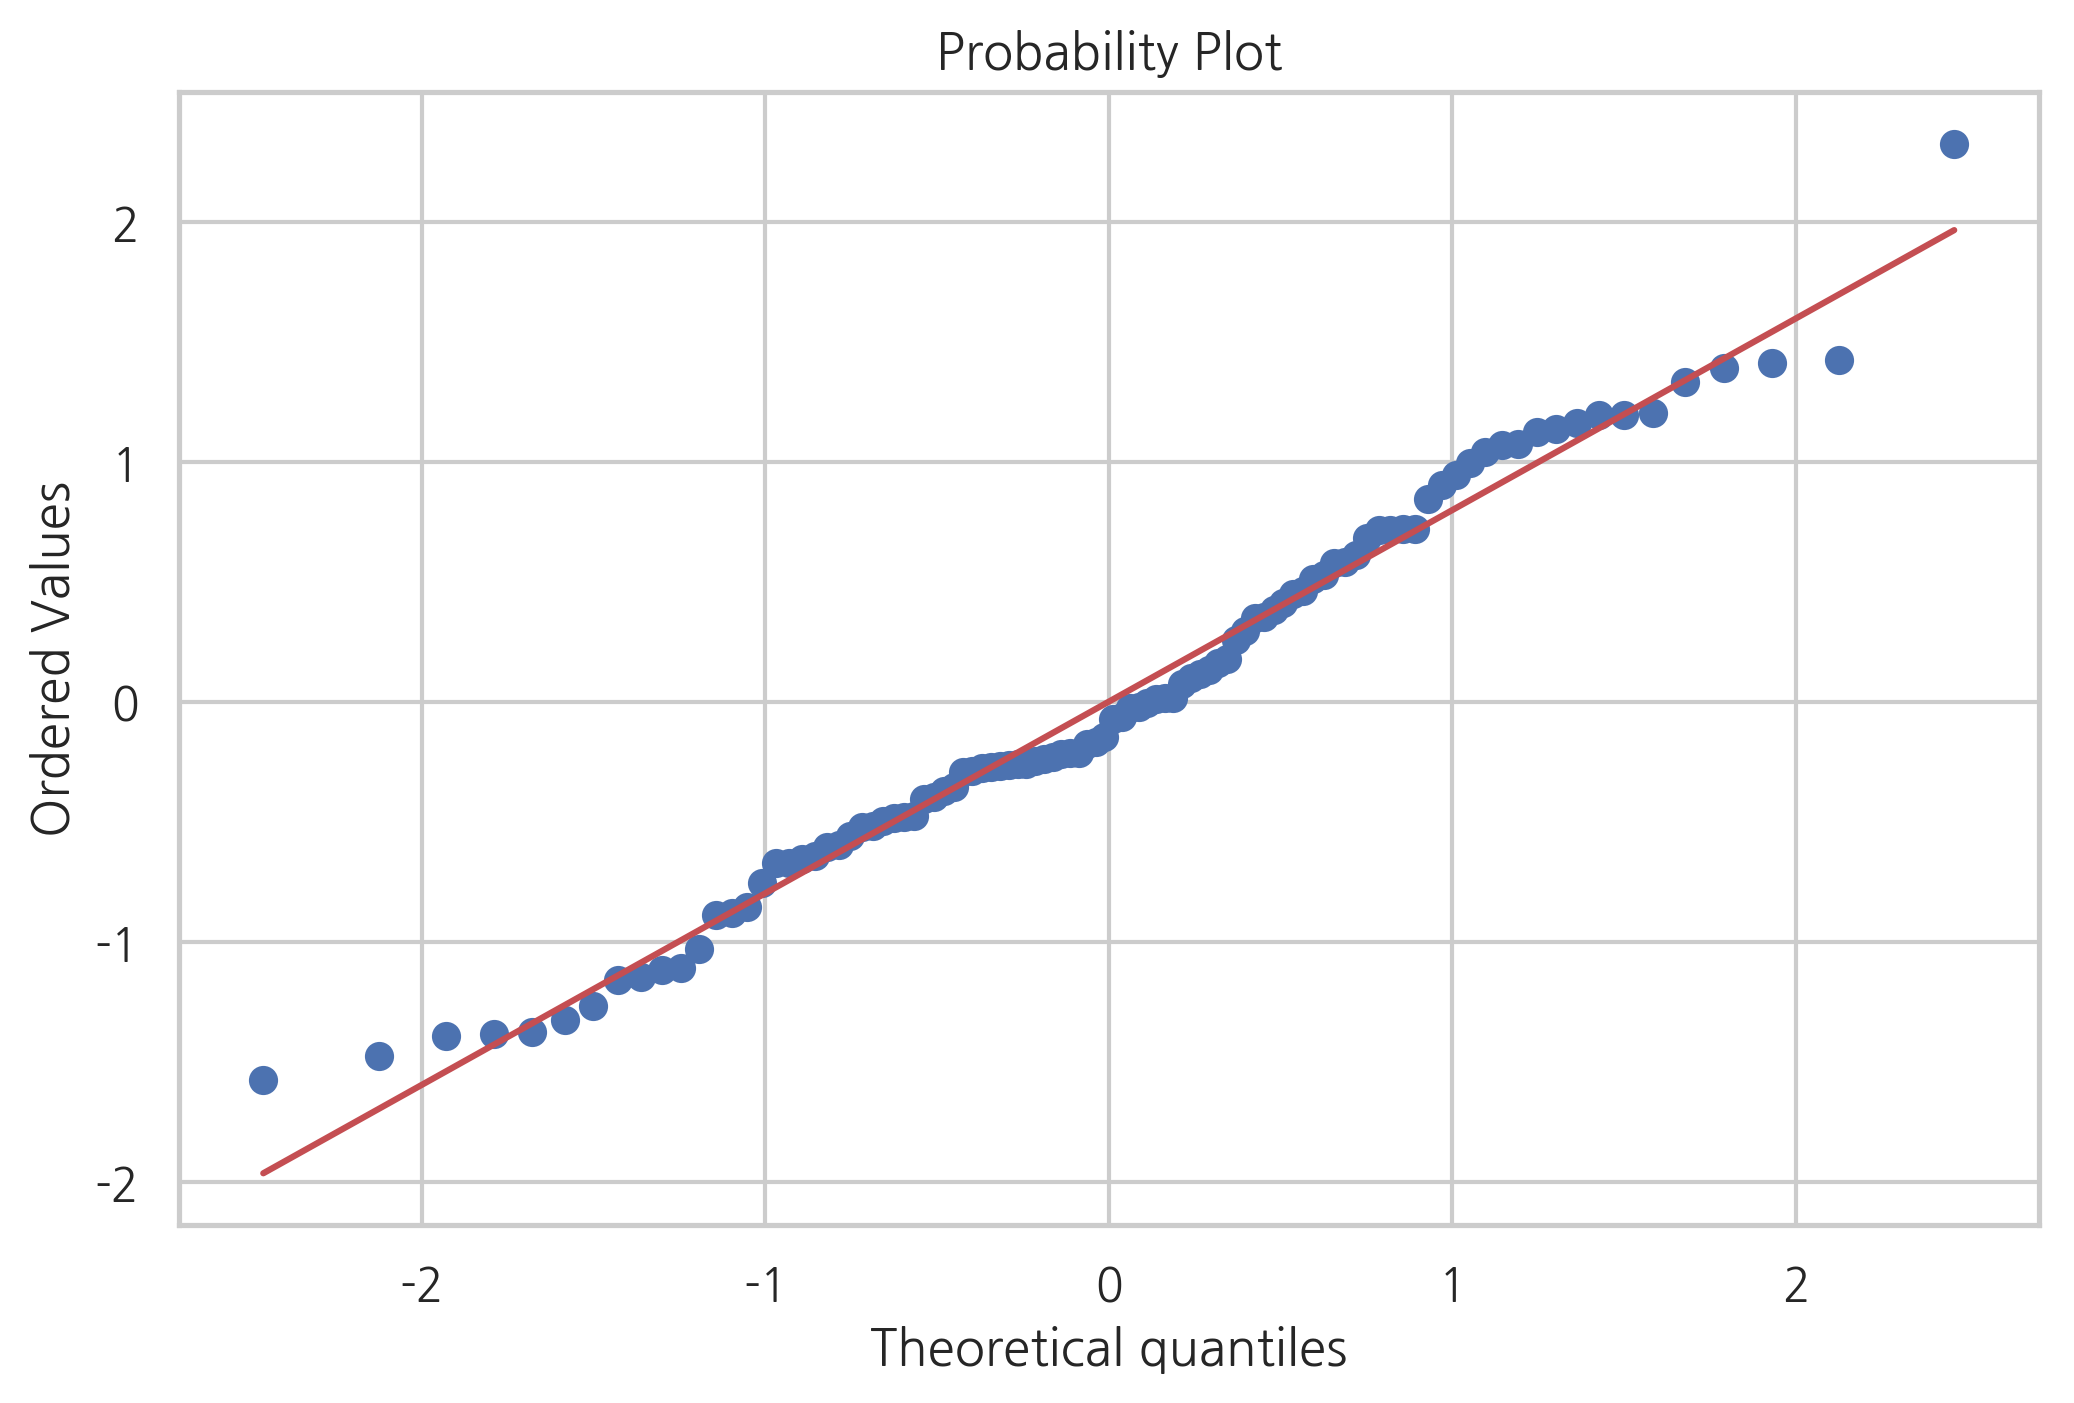

In [7]:
sp.stats.probplot(result3.resid, plot=plt)
plt.show()

In [8]:
test = sm.stats.omni_normtest(result3.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       :  1.202
P-value     :  0.548


데이터가 모형 가정을 따르지 않지만 잔차는 정규 분포를 따르는 것을 알 수 있다.

이러한 경우에는 잔차와 독립 변수간의 관계를 살펴보는 것이 도움이 될 수 있다. 데이터가 올바른 모형으로 분석되었다면 잔차는 더이상 독립 변수와 상관관계를 가지지 않아야 한다. 만약 잔차와 독립 변수간에 어떤 비선형 상관관계를 찾을 수 있다면 올바른 모형이 아니다.

다만 잔차와 특정 독립 변수간의 관계를 전체 모형이 올바른 모형이 아니라는 것을 알려줄 뿐이지 어떤 모형이 올바른 모형인지에 대한 정보는 주지 않는다.

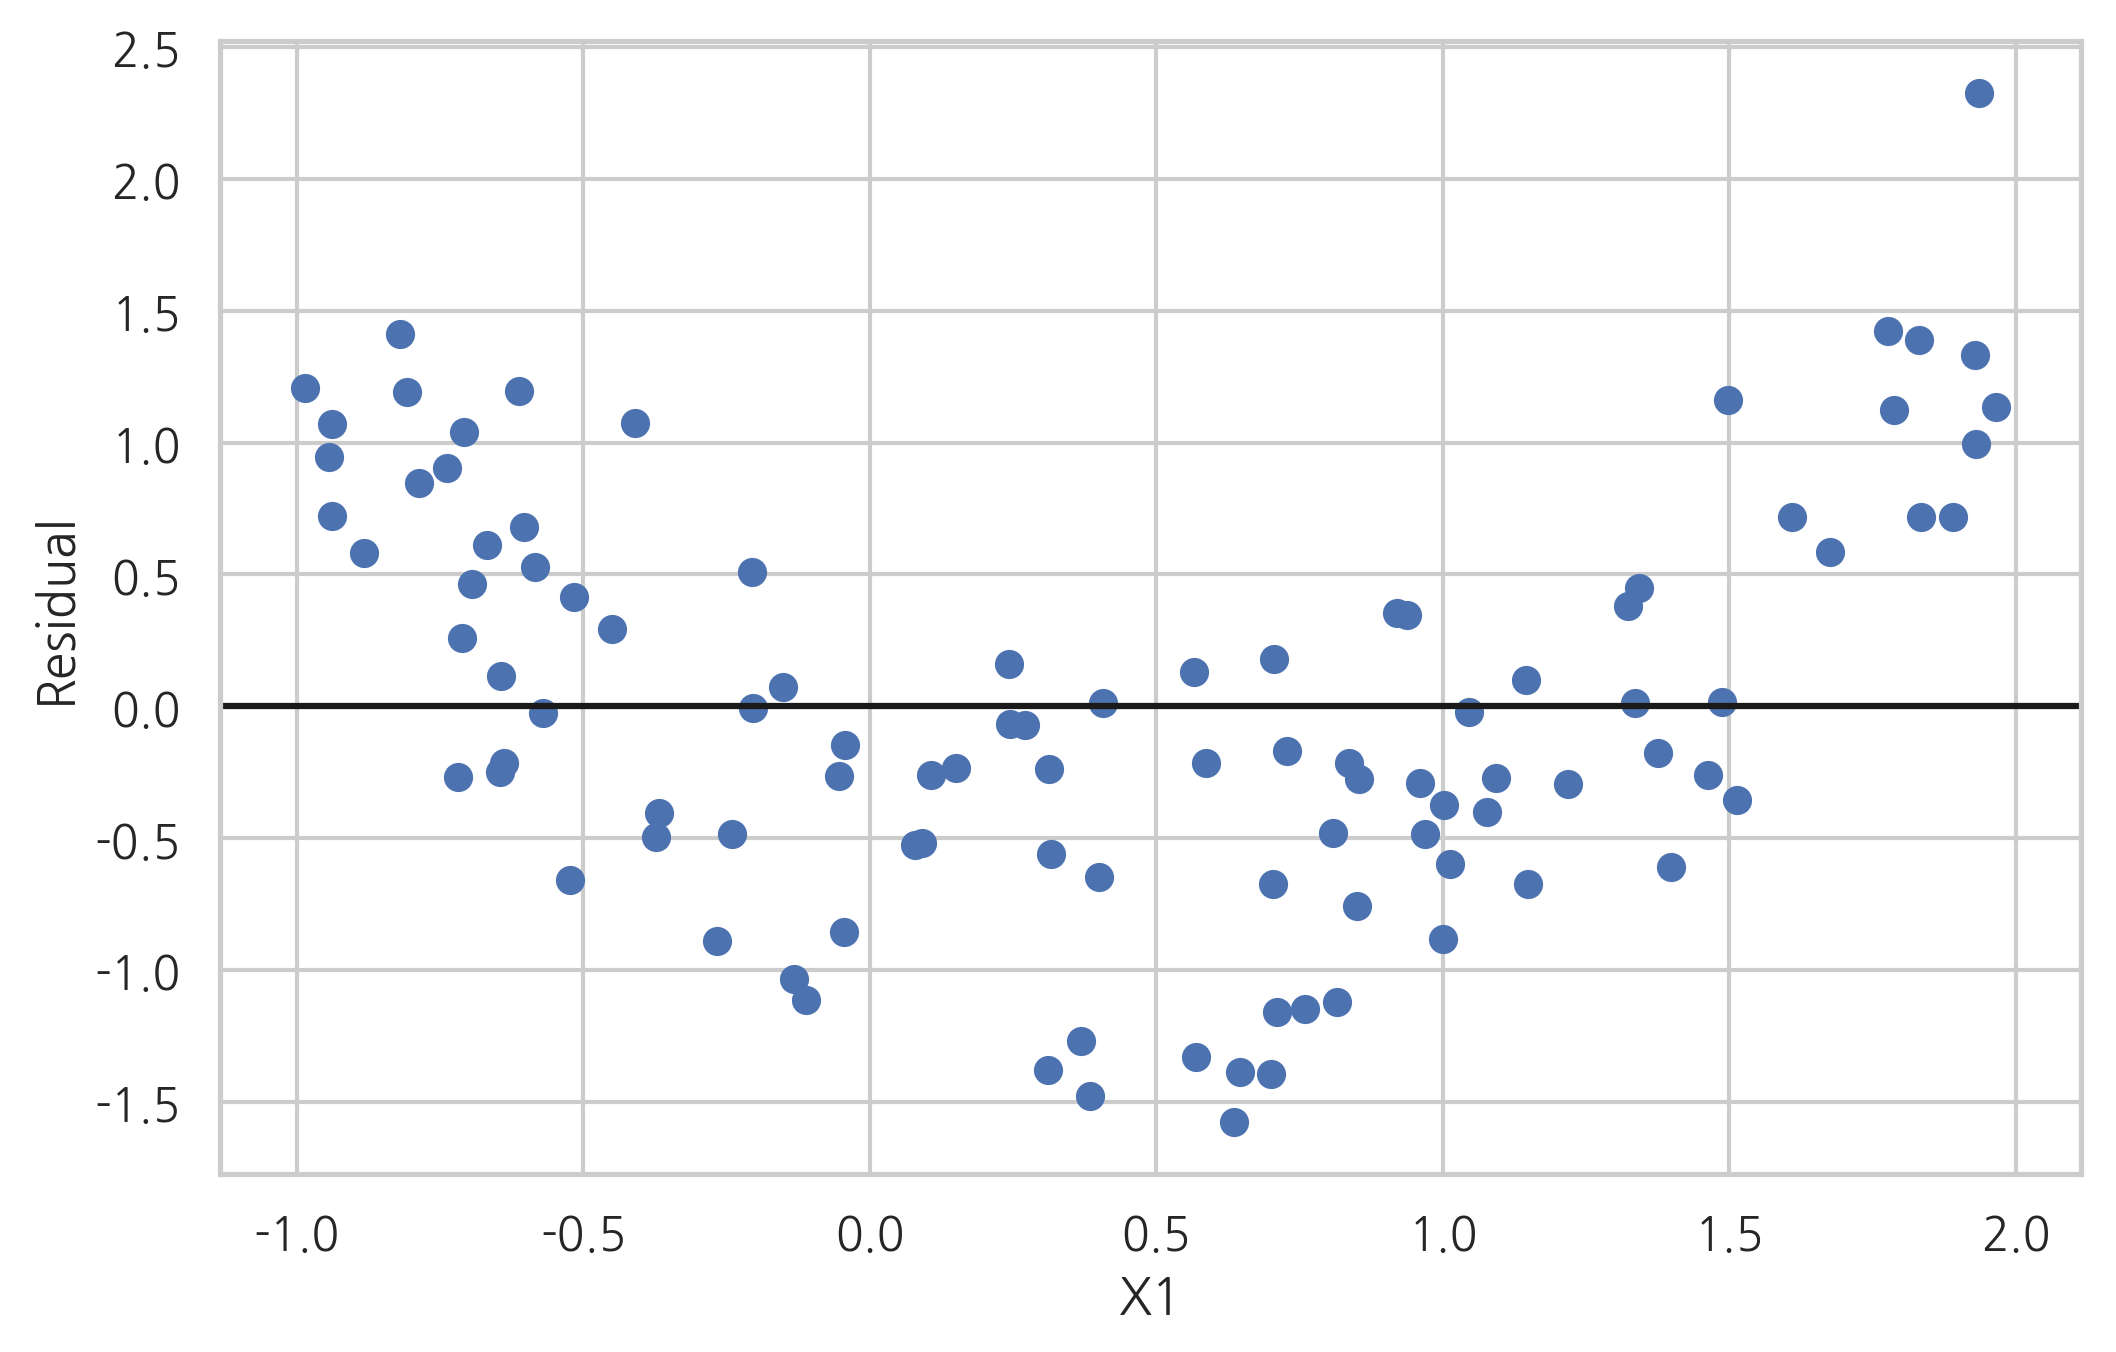

In [9]:
plt.plot(x3, result3.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel("X1")
plt.ylabel("Residual")
plt.show()

## 이분산성

선형 회귀 모형에서는 종속 변수 값의 분산이 독립 변수의 값과 상관없이 고정된 값을 가져야한다. 그러나 실제 데이터는 독립 변수 값의 크기가 커지면 종속 변수 값의 분산도 커지는 **이분산성**(heteroskedastic) 문제가 발생한다. 종속변수를 로그 변환한 트랜스로그(translog) 모형을 사용하면 이분산성 문제가 해결되는 경우도 있다.

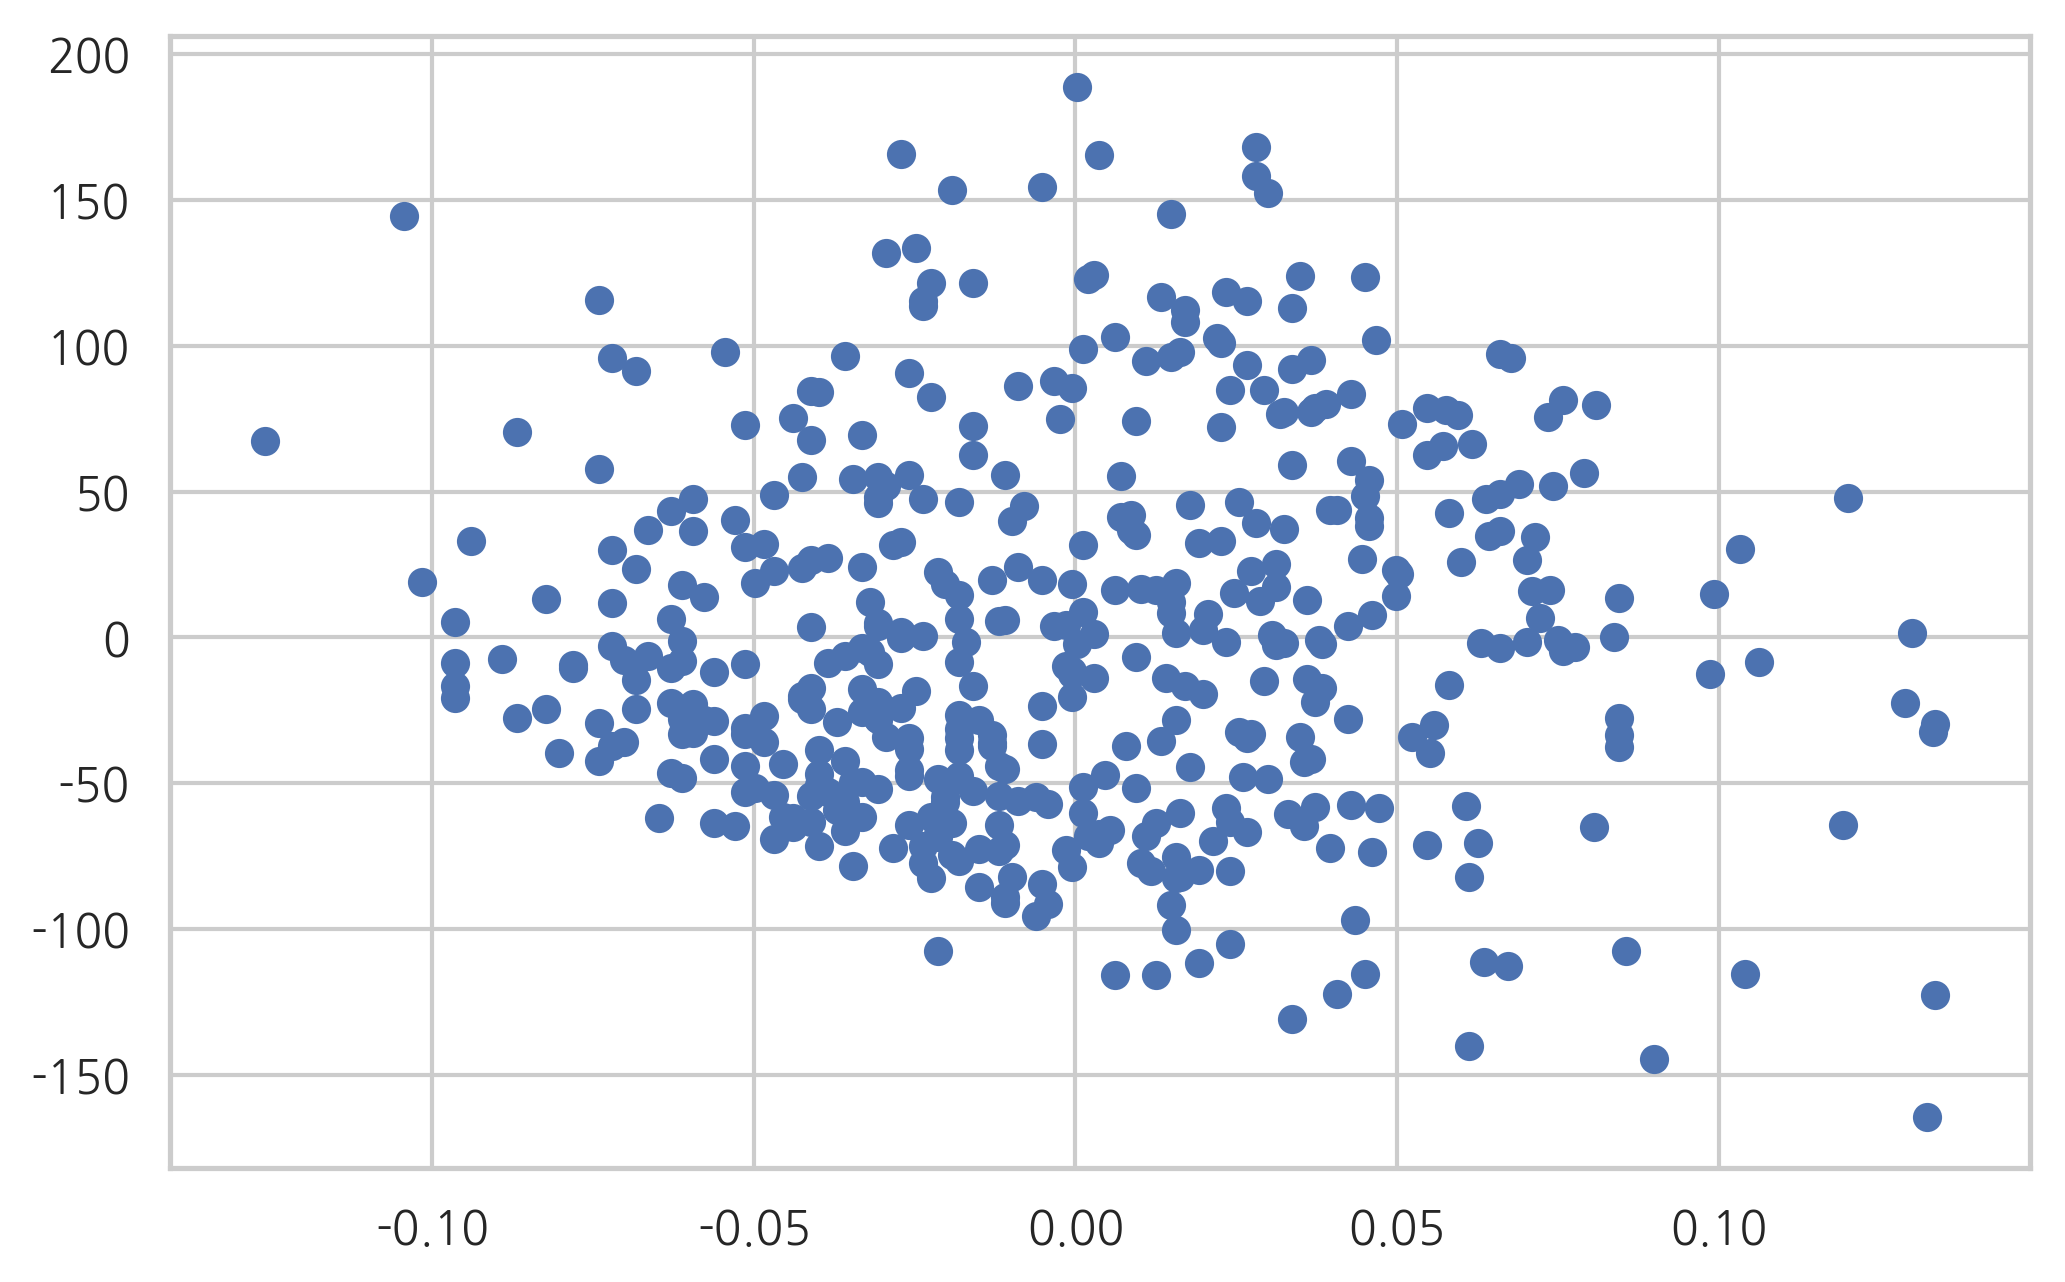

In [10]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
df = pd.concat([pd.DataFrame(diabetes.data, columns=["x%d" % (i + 1) for i in range(diabetes.data.shape[1])]),
                pd.DataFrame(diabetes.target, columns=["target"])],
               axis=1)
model = sm.OLS.from_formula("target ~ x9", data=df)
result = model.fit()
plt.scatter(df["x9"], result.resid)
plt.show()

## 자기 상관 계수

선형 회귀 모형에서는 오차(disturbance)들이 서로 (모수-조건부) 독립이라고 가정하고 있다. 따라서 잔차(residual)도 서로 독립이어야 한다. 만약 서로 독립이 아니라면 선형회귀 모형이 아닌 ARMA 모형 등의 시계열 모형을 사용해야 한다.

오차가 독립인지 검정하는 방법은 잔차를 시계열로 가정하여 자기상관계수를 구하는 것이다. 만약 독립이라면 시차(lag)가 0인 경우를 제외하고는 자기상관계수 $\rho_l$ 이 0이어야 한다. 이를 검사하는 검증으로는 다음과 같은 것들이 있다.

* Box-Pierce 검정
* Ljung-Box 검정
* Durbin-Watson 검정

이 검정들은 다음과 같은 귀무 가설을 검증한다.

$$
H_0: \rho_l = 0 \;\;\;\text{ for } i = 1, 2, \cdots, l
$$


여기에서는 회귀분석의 성능을 향상시키거나 모형이 가지는 제한조건 등을 충족시키기 위해 모형을 비선형으로 변형(transform)하는 방법에 대해 알아본다. 

### 비선형 변형

만약 독립변수와 종속변수간의 관계가 비선형이면 이 관계를 선형으로 바꿀 수 있도록 독립변수를 비선형 변환할 수 있다. 예를 들어 보스턴 집값 데이터에서 집값과 LSTAT 데이터는 다음 그림에서 보듯이 비선형 관계를 가진다.

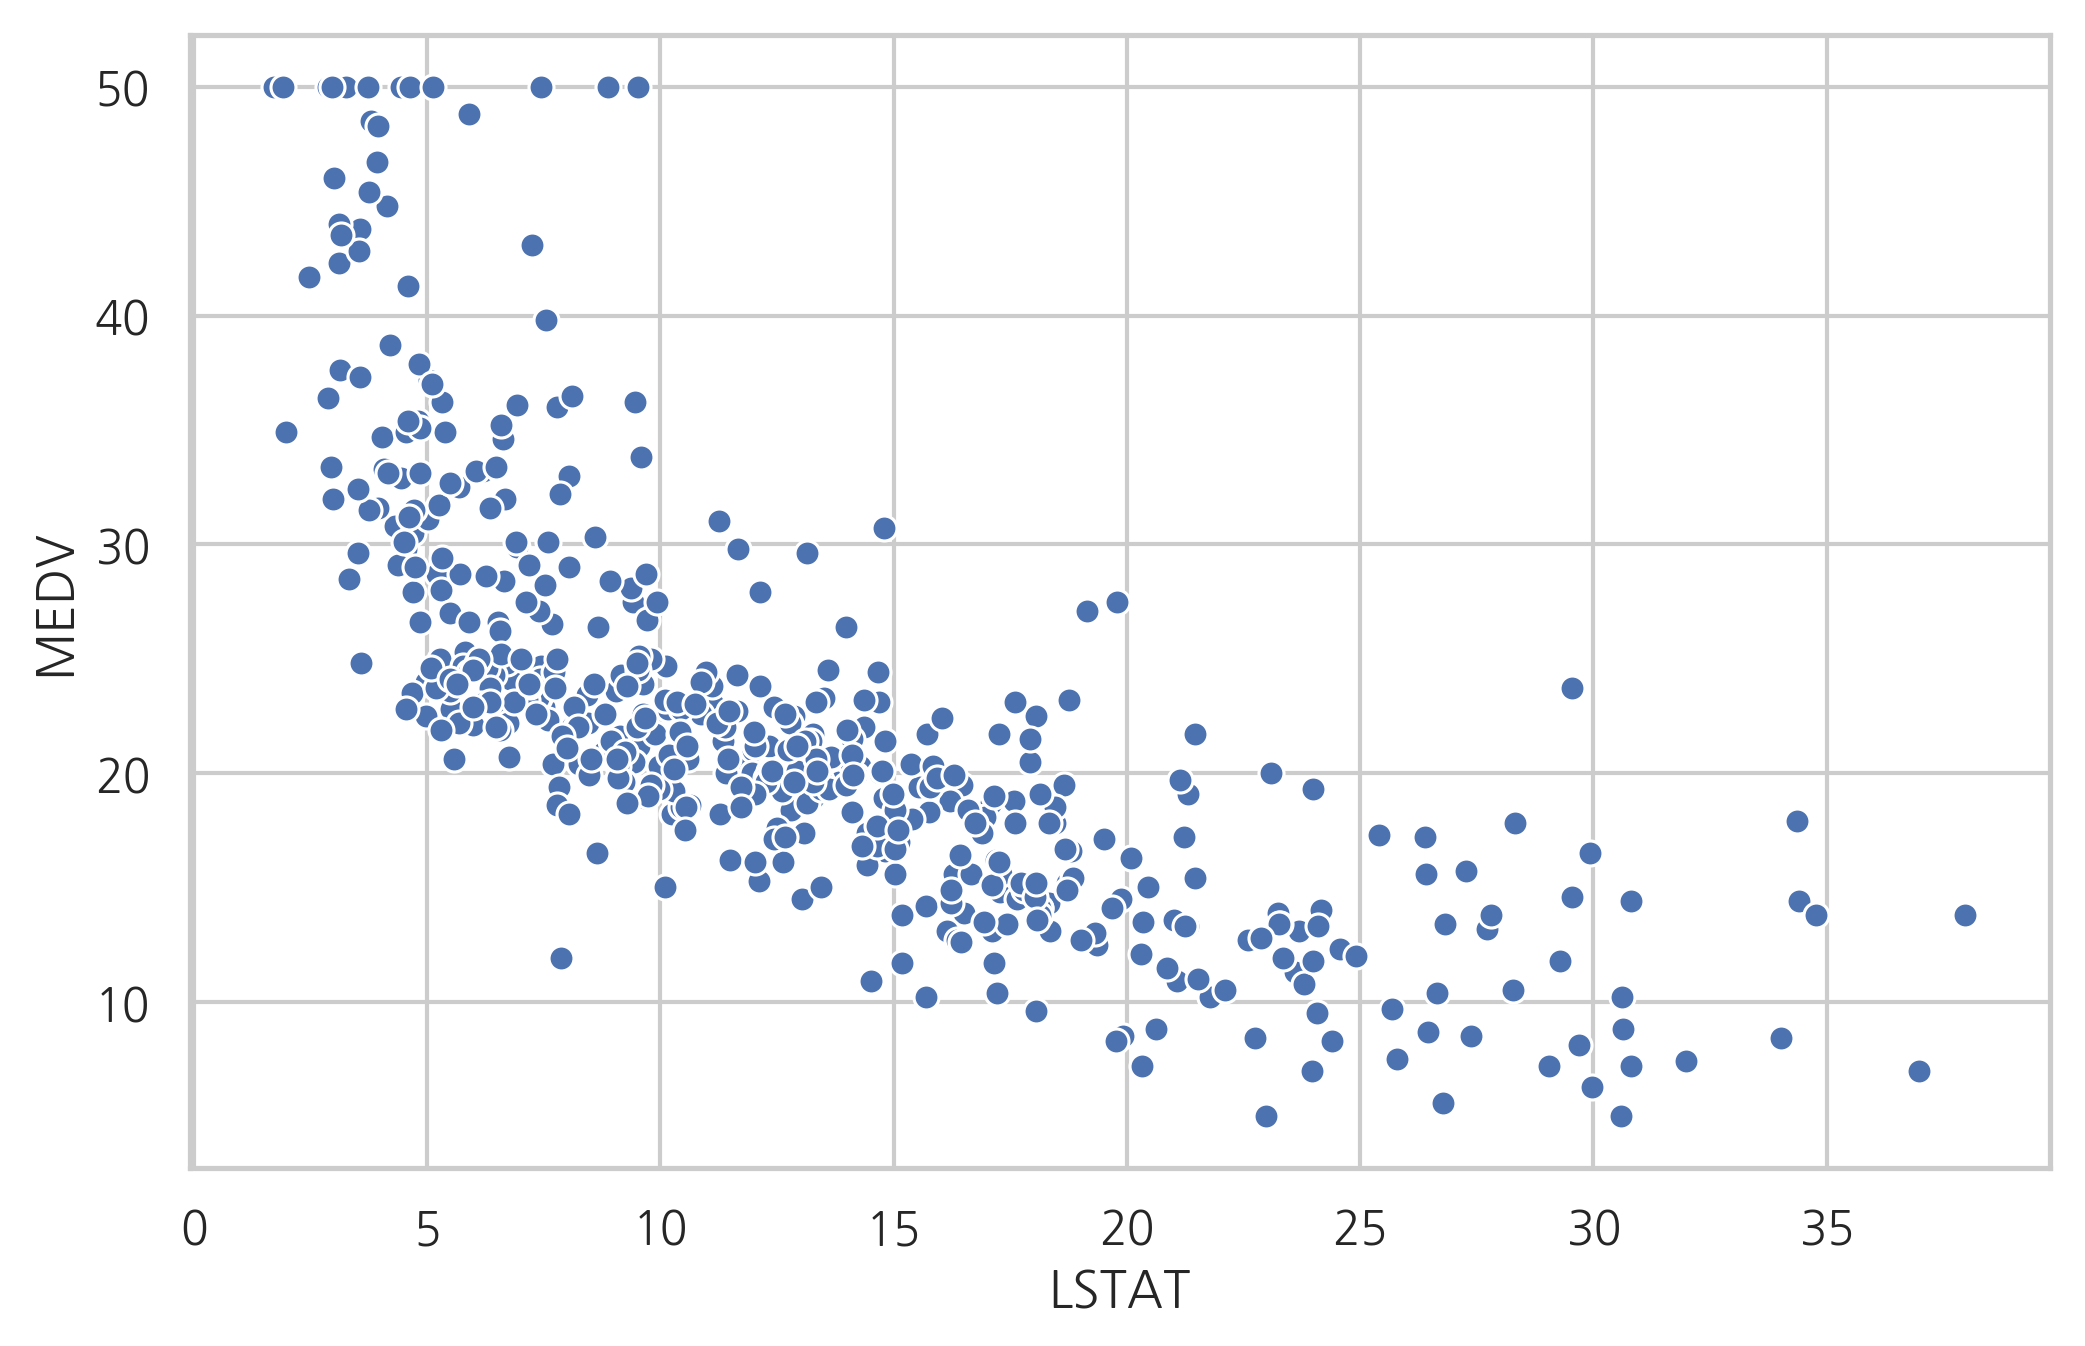

In [1]:
from sklearn.datasets import load_boston

boston = load_boston()
dfX = pd.DataFrame(boston.data, columns=boston.feature_names)
dfy = pd.DataFrame(boston.target, columns=["MEDV"])
df_boston = pd.concat([dfX, dfy], axis=1)

sns.scatterplot(x="LSTAT", y="MEDV", data=df_boston)
plt.show()

이 데이터를 그냥 사용하여 LSTAT과 종속변수간의 선형모형을 구한 결과는 다음과 같다.

In [2]:
model1 = sm.OLS.from_formula("MEDV ~ LSTAT", data=df_boston)
result1 = model1.fit()
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     601.6
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           5.08e-88
Time:                        17:28:28   Log-Likelihood:                -1641.5
No. Observations:                 506   AIC:                             3287.
Df Residuals:                     504   BIC:                             3295.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     34.5538      0.563     61.415      0.0

다음 그림은 예측값과 실제 데이터를 비교한 것이다. 선형모형이 적합하지 않음을 알 수 있다. 

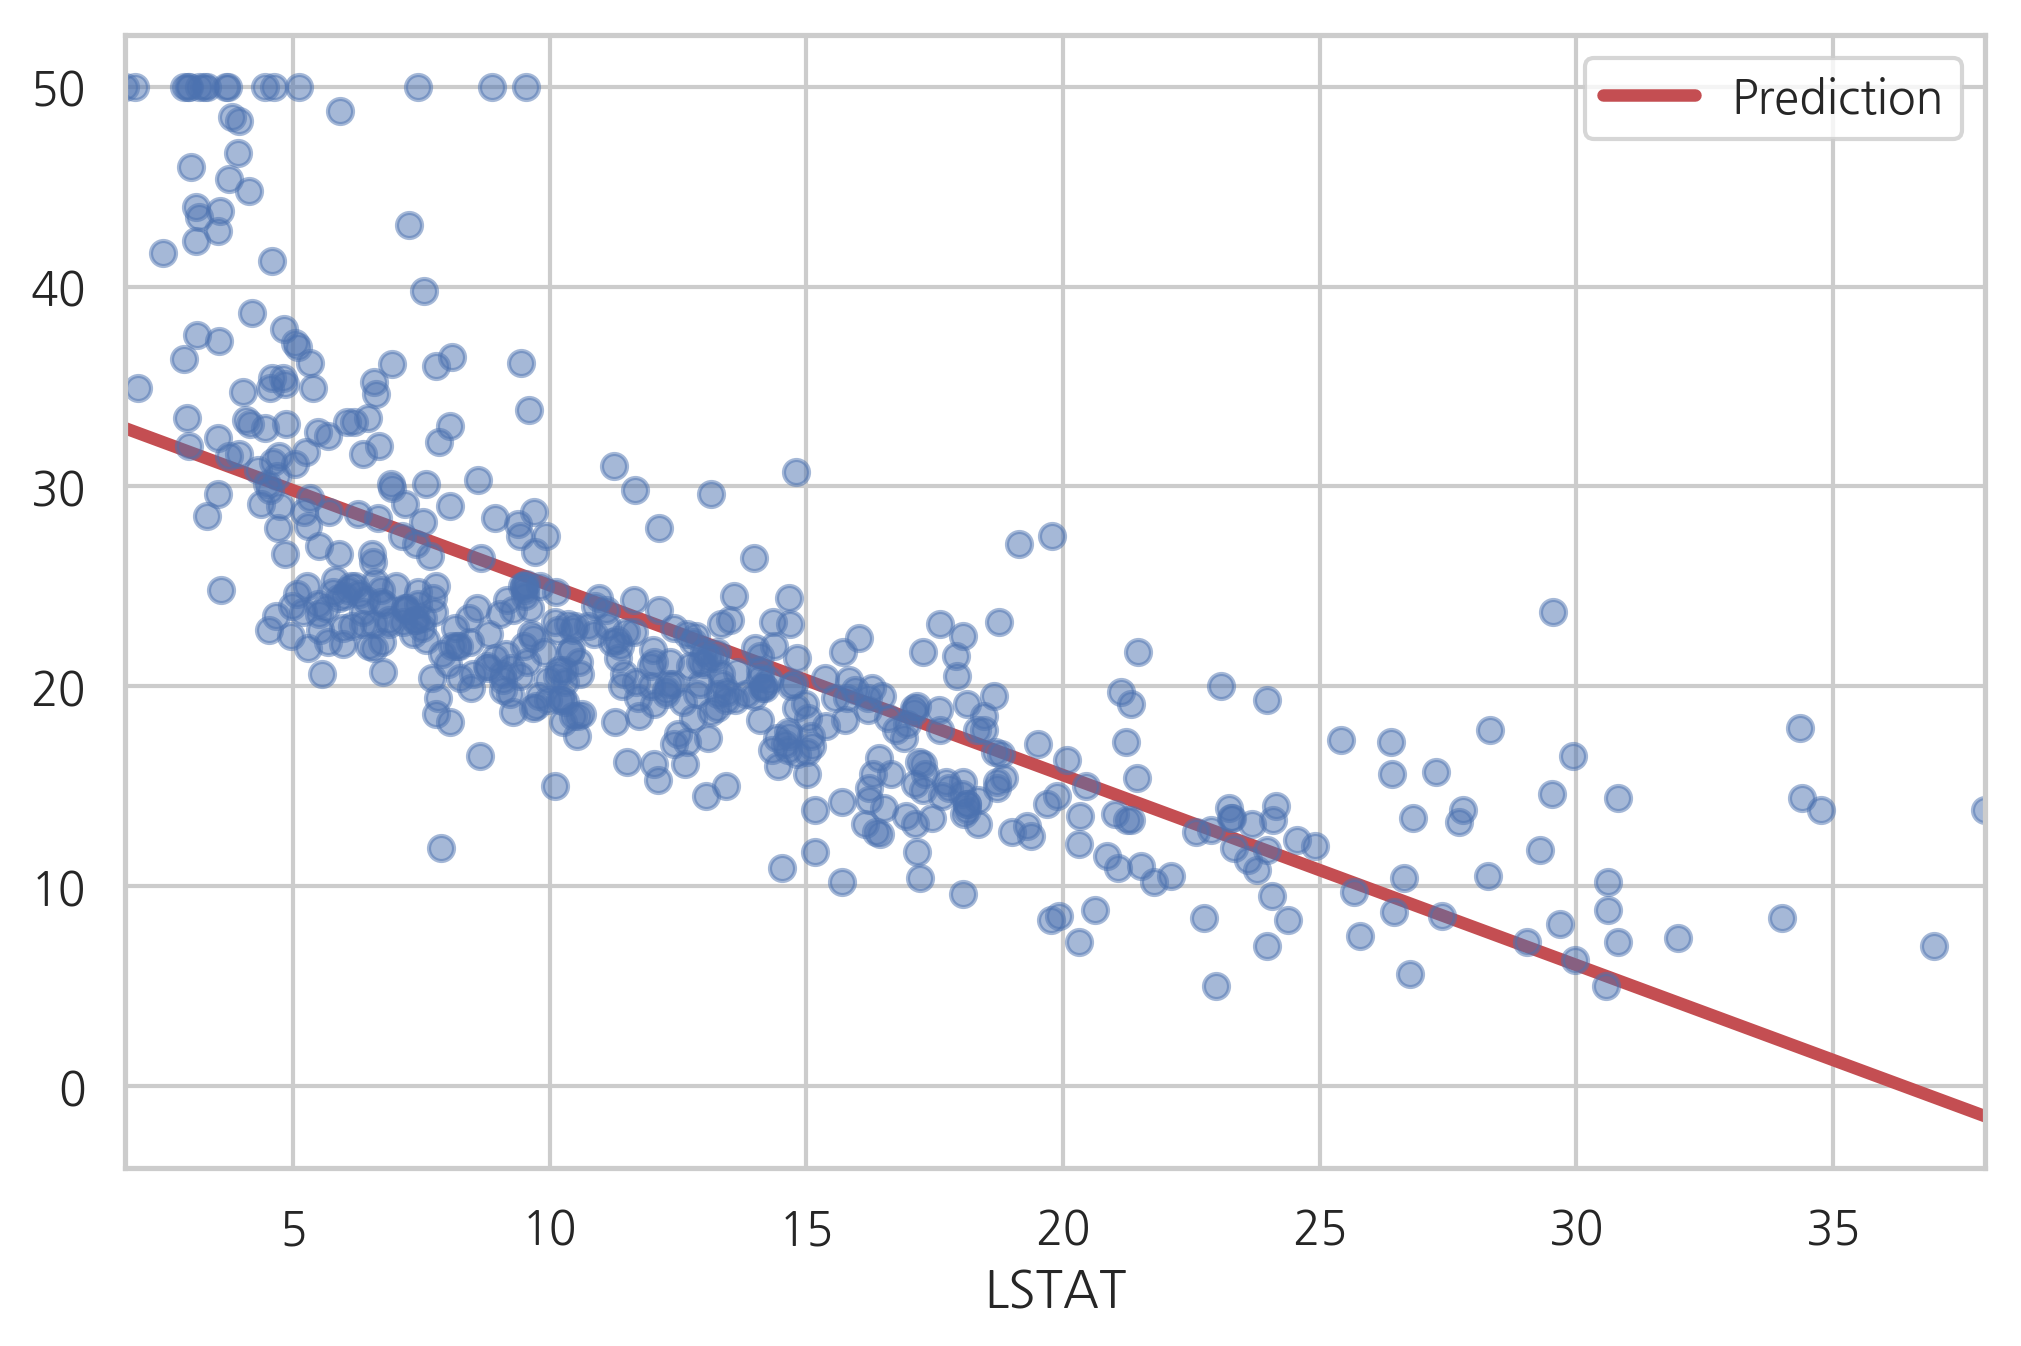

In [3]:
y_hat1 = result1.predict(df_boston)
df1 = pd.concat([y_hat1, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df1.columns = ["Prediction", "LSTAT"]
df1.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

이번에는 LSTAT값을 제곱한 비선형 독립변수를 추가한다. 결과가 향상되었다.

In [4]:
model2 = sm.OLS.from_formula("MEDV ~ LSTAT + I(LSTAT**2)", data=df_boston)
result2 = model2.fit()
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     448.5
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          1.56e-112
Time:                        17:28:28   Log-Likelihood:                -1581.3
No. Observations:                 506   AIC:                             3169.
Df Residuals:                     503   BIC:                             3181.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        42.8620      0.872     49.149

실제 데이터와 예측값을 비교해보면 선형모형보다 적합한 모형임을 알 수 있다.

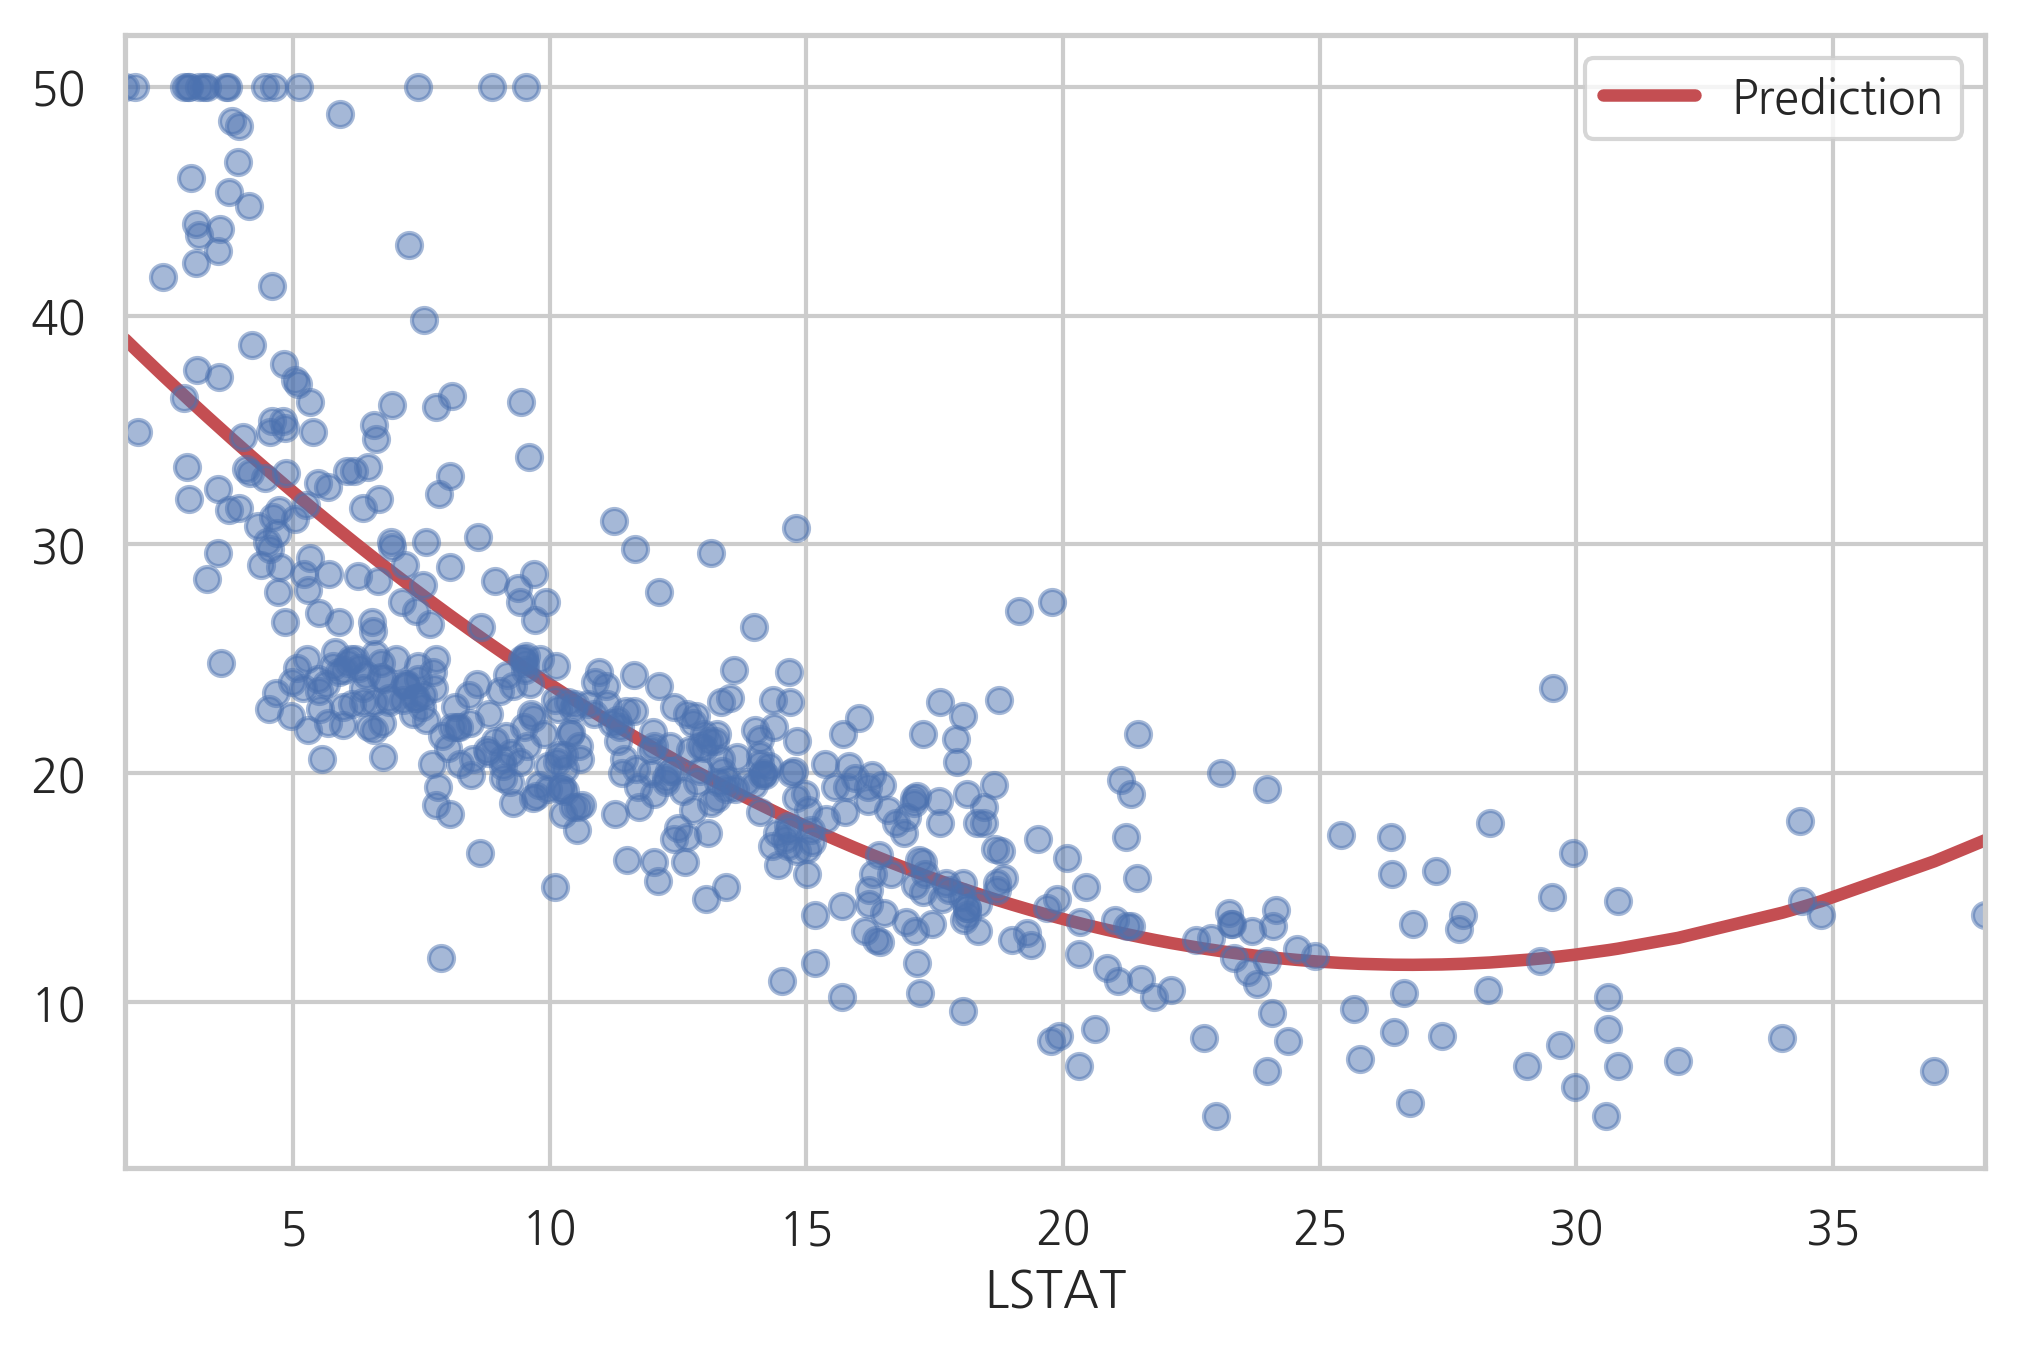

In [5]:
y_hat2 = result2.predict(df_boston)
df2 = pd.concat([y_hat2, df_boston.LSTAT], axis=1).sort_values("LSTAT")
df2.columns = ["Prediction", "LSTAT"]
df2.plot(x="LSTAT", style="r-", lw=3)
plt.plot(df_boston.LSTAT, df_boston.MEDV, "bo", alpha=0.5)
plt.show()

### 범주형을 사용한 비선형성

독립변수의 비선형성을 포착하는 또 다른 방법 중 하나는 강제로 범주형 값으로 만드는 것이다. 범주형 값이 되면서 독립변수의 오차가 생기지만 이로 인한 오차보다 비선형성으로 얻을 수 있는 이익이 클 수도 있다. 

보스턴 집값 데이터에서 종속변수와 RM 변수의 관계는 선형에 가깝지만 방의 갯수가 아주 작아지거나 아주 커지면 선형모형에서 벗어난다. 

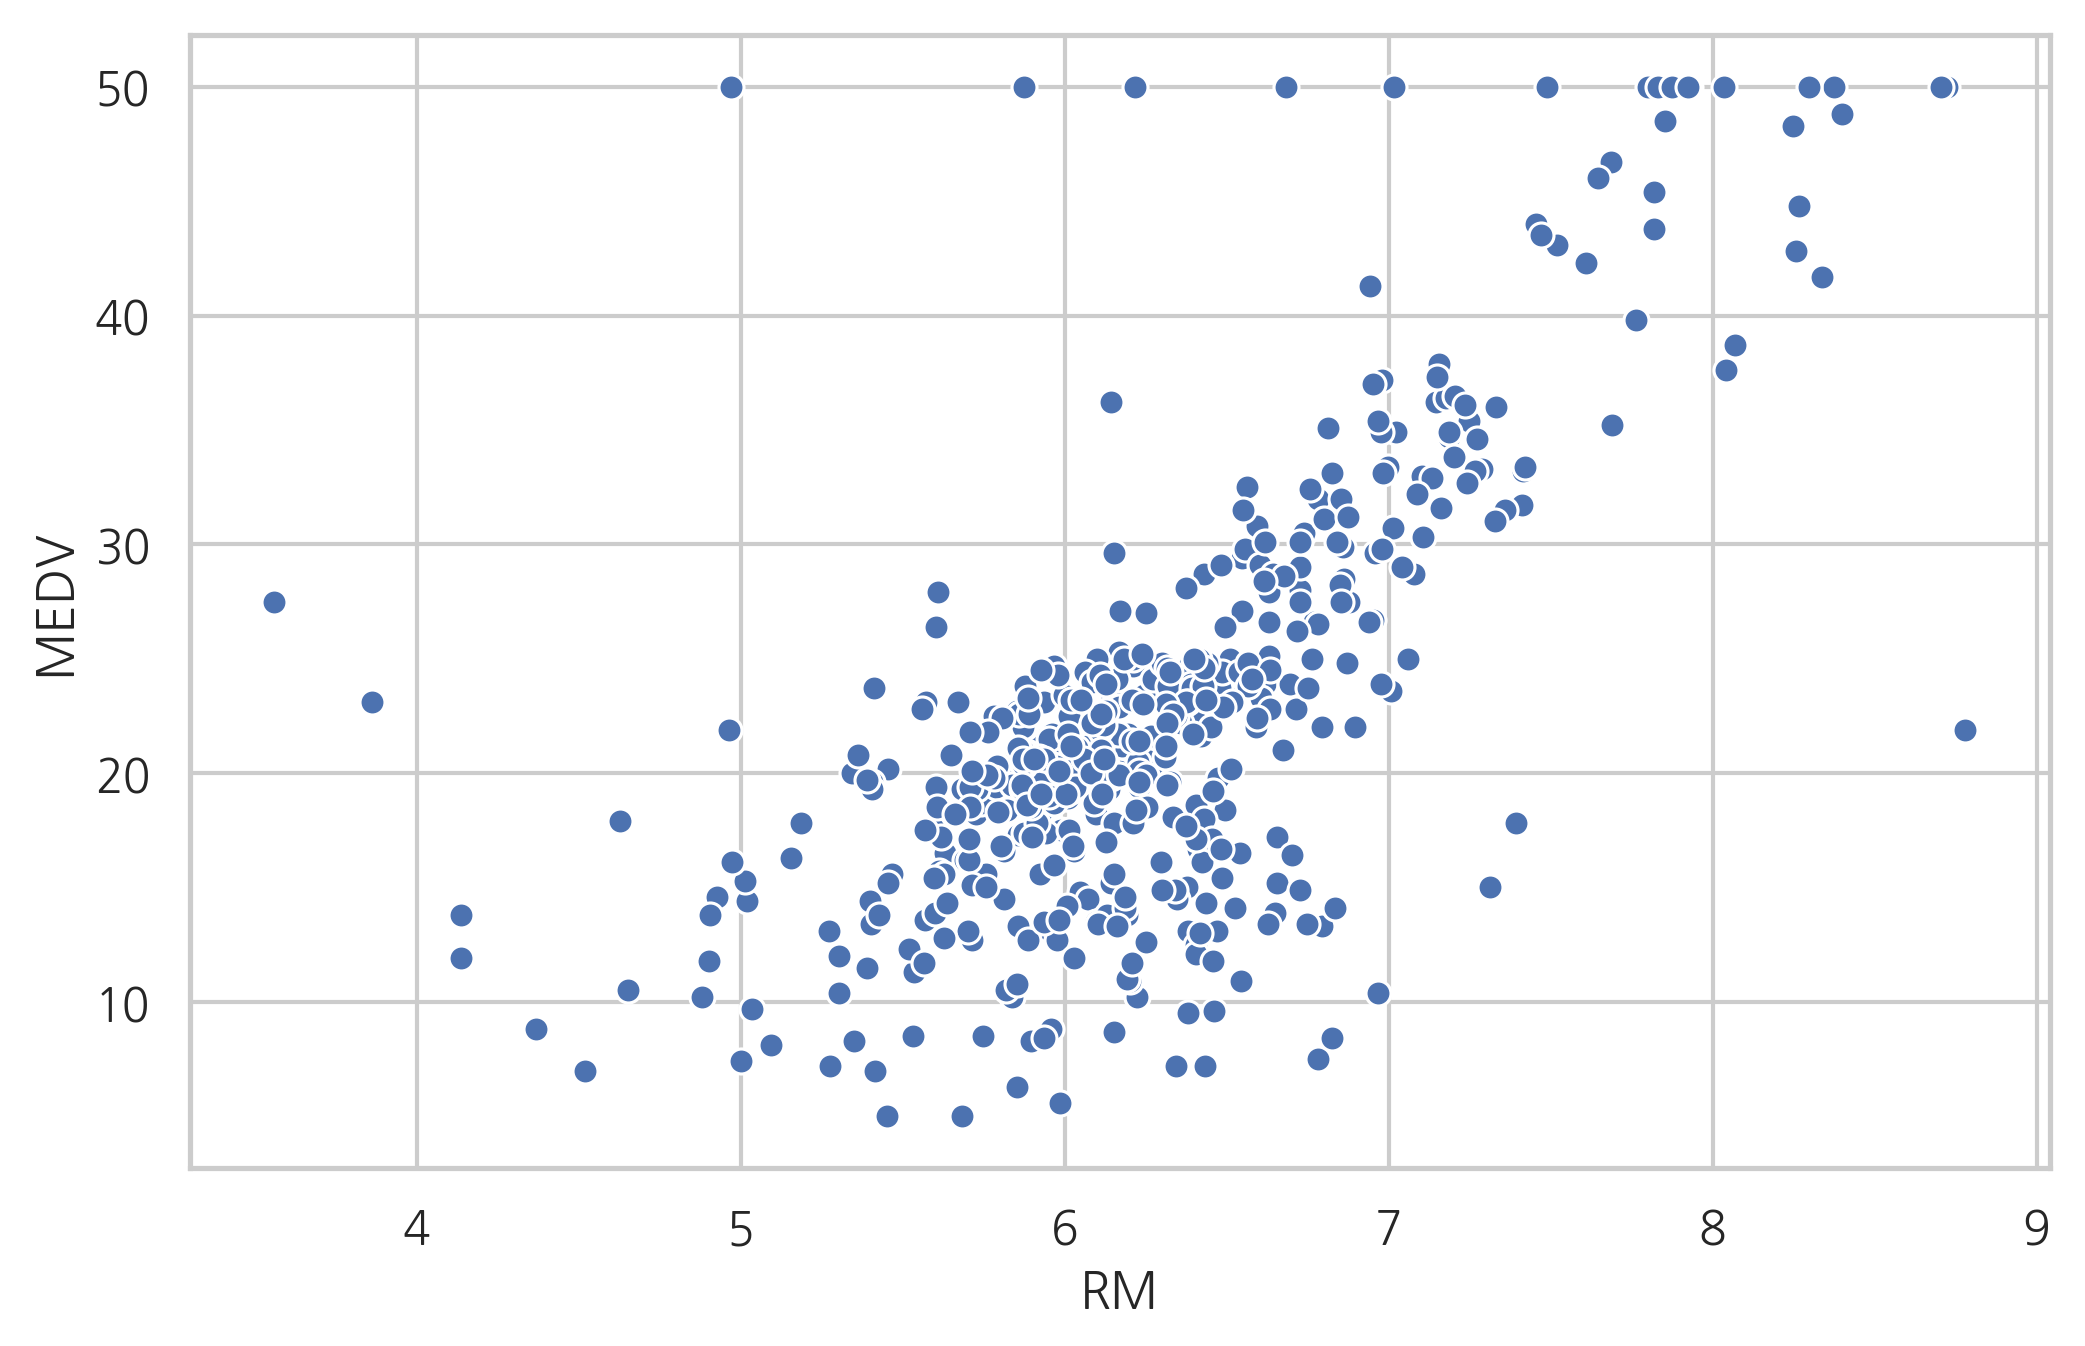

In [6]:
sns.scatterplot(x="RM", y="MEDV", data=df_boston)
plt.show()

In [7]:
model3 = sm.OLS.from_formula("MEDV ~ RM", data=df_boston)
result3 = model3.fit()
print(result3.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           2.49e-74
Time:                        17:28:29   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

RM 변수값을 강제로 정수로 라운딩(rounding)하면 RM 변수가 가지는 비선형성을 잡을 수 있다. 다음 플롯은 카테고리값으로 변한 RM 변수와 종속변수의 관계를 시각화한 것이다.

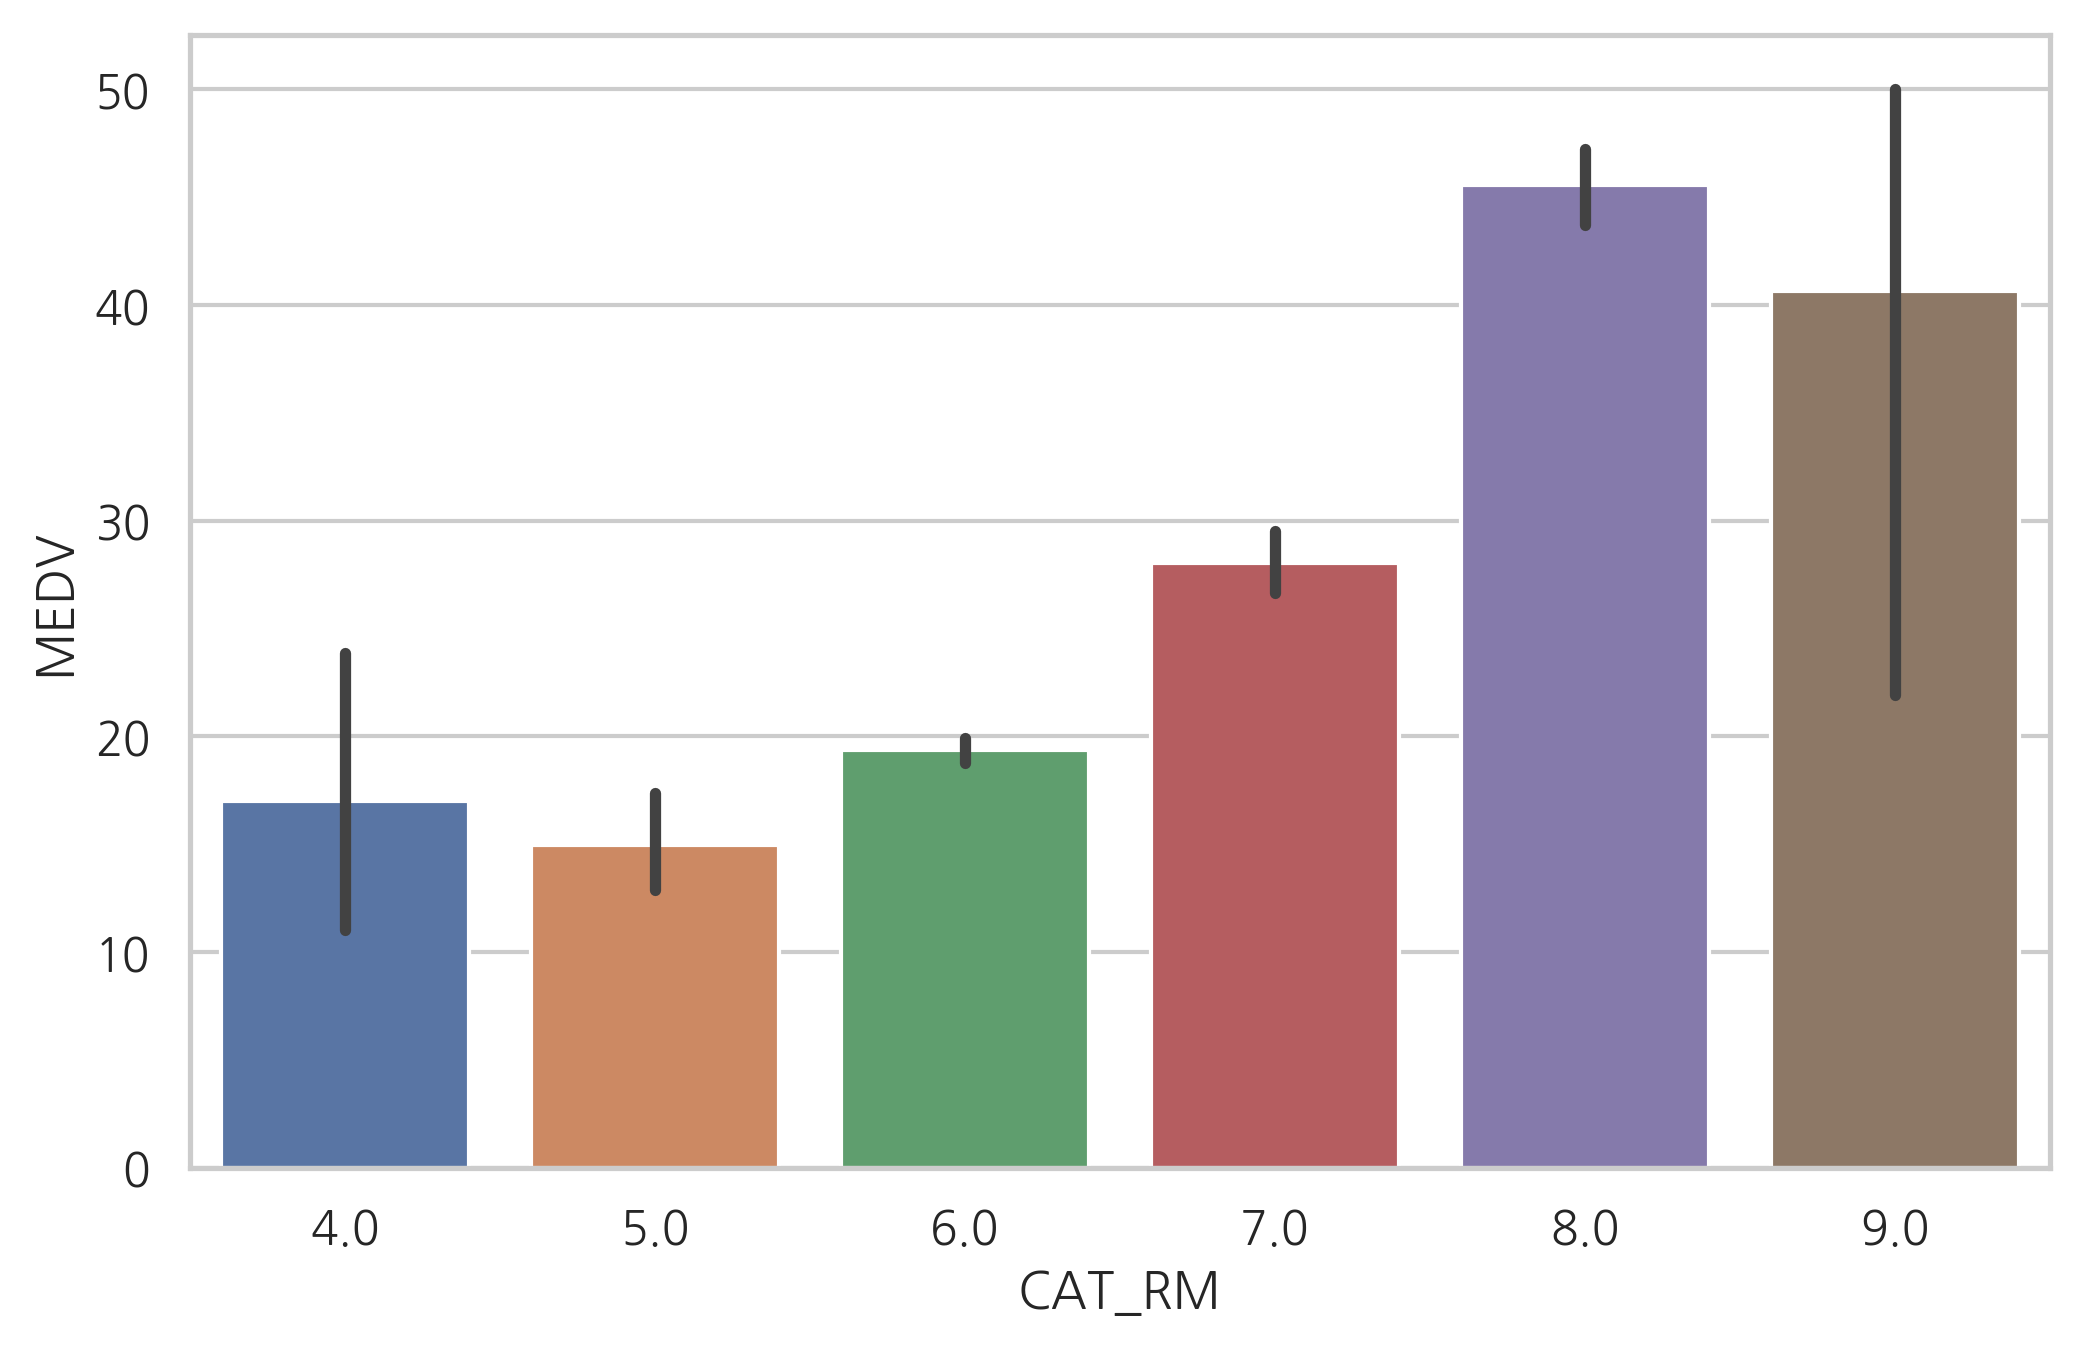

In [8]:
rooms = np.arange(3, 10)
labels = [str(r) for r in rooms[:-1]]
df_boston["CAT_RM"] = np.round(df_boston.RM)

sns.barplot(x="CAT_RM", y="MEDV", data=df_boston)
plt.show()

이렇게 하면 RM 변수으로 인한 종속변수의 변화를 비선형 상수항으로 모형화 할 수 있다. 선형모형보다 성능이 향상된 것을 볼 수 있다.

In [9]:
model4 = sm.OLS.from_formula("MEDV ~ C(np.round(RM))", data=df_boston)
result4 = model4.fit()
print(result4.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     115.8
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           3.57e-81
Time:                        17:28:29   Log-Likelihood:                -1645.6
No. Observations:                 506   AIC:                             3303.
Df Residuals:                     500   BIC:                             3329.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                 17

### 시간 독립변수의 변형

독립변수가 시간인 경우에는 특정 시점에서 경과된 시간값으로 변형해야 한다. 일간 전기 사용량 데이터를 예로 들어 설명한다.

In [10]:
data = sm.datasets.get_rdataset("elecdaily", package="fpp2")

df_elec = data.data.drop(columns=["WorkDay", "Temperature"])
df_elec["Date"] = pd.date_range("2014-1-1", "2014-12-31")
df_elec.tail()

Demand       Date
360  173.727990 2014-12-27
361  188.512817 2014-12-28
362  191.273009 2014-12-29
363  186.240144 2014-12-30
364  186.370181 2014-12-31

파이썬 `datetime` 자료형은 `toordinal` 명령으로 특정 시점으로부터 경과한 시간의 일단위 값을 구하거나  `timestamp` 메서드로 초단위 값을 구할 수 있다.

In [11]:
import datetime as dt

df_elec["Ordinal"] = df_elec.Date.map(dt.datetime.toordinal)
df_elec["Timestamp"] = df_elec.Date.map(dt.datetime.timestamp)
df_elec.tail()

Demand       Date  Ordinal     Timestamp
360  173.727990 2014-12-27   735594  1.419606e+09
361  188.512817 2014-12-28   735595  1.419692e+09
362  191.273009 2014-12-29   735596  1.419779e+09
363  186.240144 2014-12-30   735597  1.419865e+09
364  186.370181 2014-12-31   735598  1.419952e+09

여기에서는 일단위 시간 값을 사용하여 회귀분석을 한다. 시간 값의 경우 크기가 크므로 반드시 스케일링을 해 주어야 한다.

In [12]:
model5 = sm.OLS.from_formula("Demand ~ scale(Ordinal)", data=df_elec)
result5 = model5.fit()
print(result5.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     11.58
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           0.000739
Time:                        17:28:32   Log-Likelihood:                -1709.7
No. Observations:                 365   AIC:                             3423.
Df Residuals:                     363   BIC:                             3431.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        221.2775      1.374    160.

하지만 시간 독립변수는 이 외에더 다양한 특징들을 숨기고 있다. 예들 들어 연도, 월, 일, 요일 데이터를 별도의 독립변수로 분리하거나 한 달 내에서 몇번째 날짜인지 월의 시작 또는 끝인지를 나타내는 값은 모두 특징값이 될 수 있다. 판다스에서는 `dt` 특수 연산자를 사용하여 이러한 값을 구할 수 있다. 

In [13]:
df_elec["Year"] = df_elec.Date.dt.year
df_elec["Month"] = df_elec.Date.dt.month
df_elec["DayOfYear"] = df_elec.Date.dt.dayofyear
df_elec["DayOfMonth"] = df_elec.Date.dt.daysinmonth
df_elec["DayOfWeek"] = df_elec.Date.dt.dayofweek
df_elec["WeekOfYear"] = df_elec.Date.dt.weekofyear
df_elec["Weekday"] = df_elec.Date.dt.weekday
df_elec["IsMonthStart"] = df_elec.Date.dt.is_month_start
df_elec["IsMonthEnd"] = df_elec.Date.dt.is_month_end
df_elec.tail()

Demand       Date  Ordinal     Timestamp  Year  Month  DayOfYear  \
360  173.727990 2014-12-27   735594  1.419606e+09  2014     12        361   
361  188.512817 2014-12-28   735595  1.419692e+09  2014     12        362   
362  191.273009 2014-12-29   735596  1.419779e+09  2014     12        363   
363  186.240144 2014-12-30   735597  1.419865e+09  2014     12        364   
364  186.370181 2014-12-31   735598  1.419952e+09  2014     12        365   

     DayOfMonth  DayOfWeek  WeekOfYear  Weekday  IsMonthStart  IsMonthEnd  
360          31          5          52        5         False       False  
361          31          6          52        6         False       False  
362          31          0           1        0         False       False  
363          31          1           1        1         False       False  
364          31          2           1        2         False        True

이렇게 추가적인 특징값을 이용하여 구한 모형은 성능이 향상된다.

In [14]:
feature_names = df_elec.columns.tolist()
feature_names.remove("Demand")
feature_names.remove("Date")

formula = """
Demand ~ scale(Ordinal) + C(Month) + DayOfYear + 
         C(DayOfMonth) + C(DayOfWeek) + C(Weekday) + C(IsMonthStart) + C(IsMonthEnd)
"""
model6 = sm.OLS.from_formula(formula, data=df_elec)
result6 = model6.fit()
print(result6.summary())

                            OLS Regression Results                            
Dep. Variable:                 Demand   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.511
Method:                 Least Squares   F-statistic:                     19.98
Date:                Mon, 17 Jun 2019   Prob (F-statistic):           4.74e-46
Time:                        17:28:32   Log-Likelihood:                -1574.8
No. Observations:                 365   AIC:                             3192.
Df Residuals:                     344   BIC:                             3273.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

### 주기성을 가지는 독립변수

독립변수가 주기성을 가지는 경우에는 그대로 사용하면 모형이 주기성을 가지지 못한다. 예를 들어 scikit-learn의 covtype 데이터를 살펴보자. 이 데이터는 원래 특징값들로부터 특정 범주값을 예측하는 분류 문제용 데이터 집합이지만 Aspect라는 변수를 독립변수로 하고 Hillshade_9am라는 변수를 종속변수로 하는 회귀분석 문제로 가정한다. 

In [15]:
from sklearn.datasets import fetch_covtype

covtype = fetch_covtype()

feature_names = ["Aspect", "Hillshade_9am"]
df_covtype = pd.DataFrame(covtype.data[:, [1, 6]], columns=feature_names)
df_covtype = df_covtype.sample(10000, random_state=0)  # 편의상 10,000개 표본 추출
df_covtype.tail()

Aspect  Hillshade_9am
77297     90.0          235.0
103214    38.0          220.0
459385    79.0          241.0
159359    58.0          225.0
565783    91.0          240.0

Aspect 변수는 도(degree) 단위의 각도를 나타내는 독립변수이므로 0부터 360까지의 값을 가진다. Aspect가 0인 경우와 360인 경우는 독립변수가 실질적으로 같기 때문에 같은 종속변수값을 예측해야 한다.

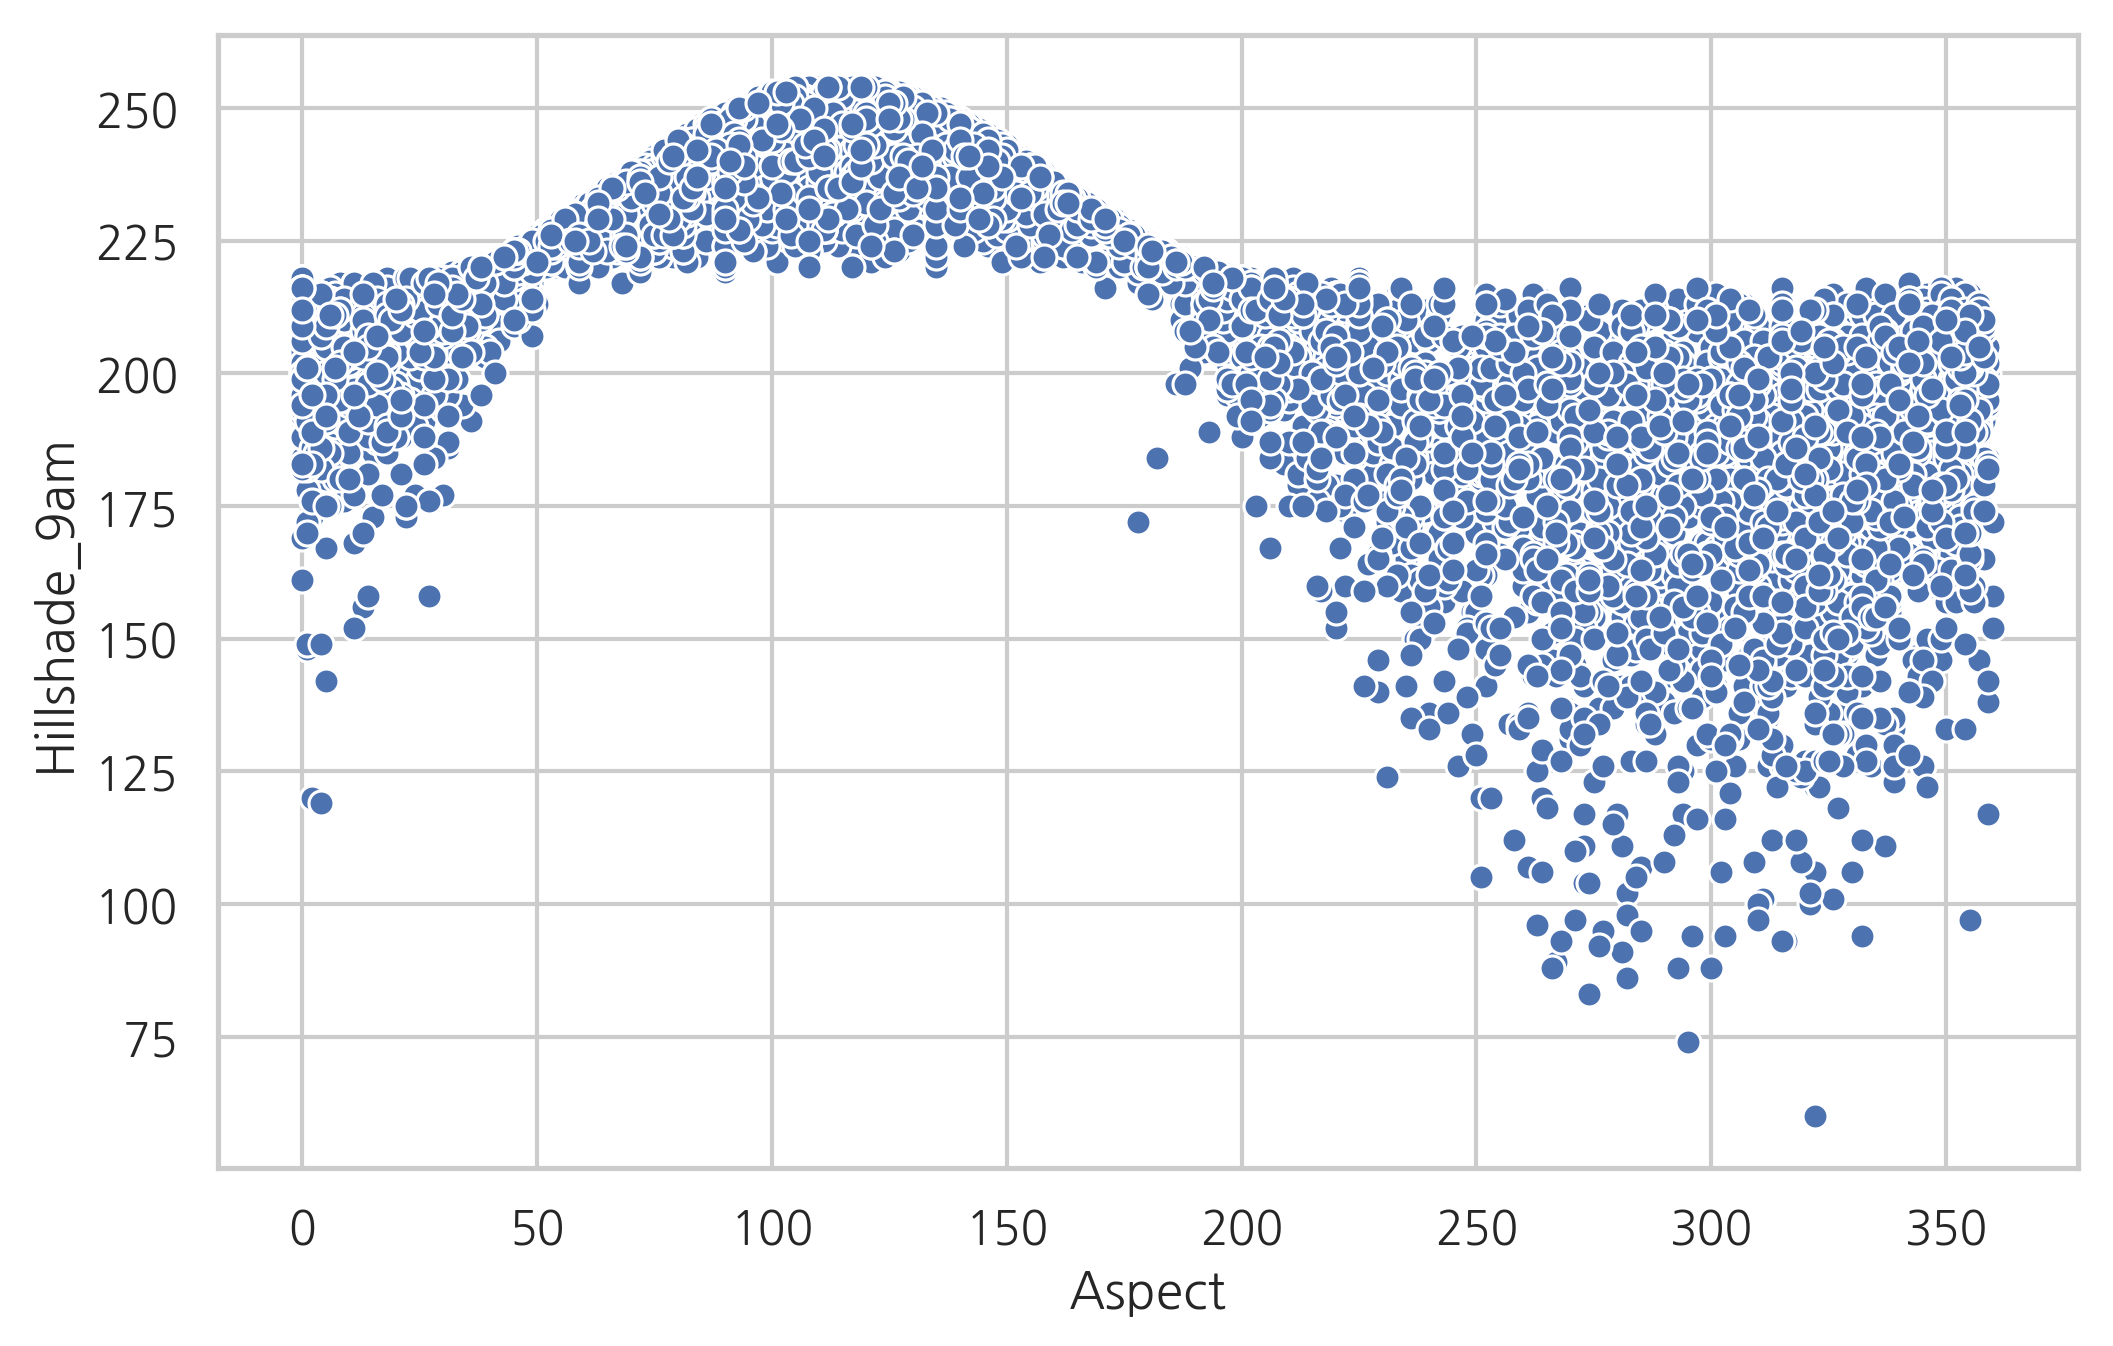

In [16]:
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.show()

하지만 Aspect를 일반 실수형 독립변수처럼 사용하면 Aspect가 0도일 때와 360도일 때 다른 종속변수값이 예측된다. 

In [17]:
model7 = sm.OLS.from_formula(
    "Hillshade_9am ~ Aspect + I(Aspect**2) + I(Aspect**3)", 
    data=df_covtype
)
result7 = model7.fit()
print(result7.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.705
Method:                 Least Squares   F-statistic:                     7974.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:28:33   Log-Likelihood:                -40905.
No. Observations:               10000   AIC:                         8.182e+04
Df Residuals:                    9996   BIC:                         8.185e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        187.0395      0.485    385.

In [18]:
df_test = pd.DataFrame([[0], [360]], columns=["Aspect"])
df_result7 = result7.predict(df_test)
df_result7

0    187.039453
1    193.002560
dtype: float64

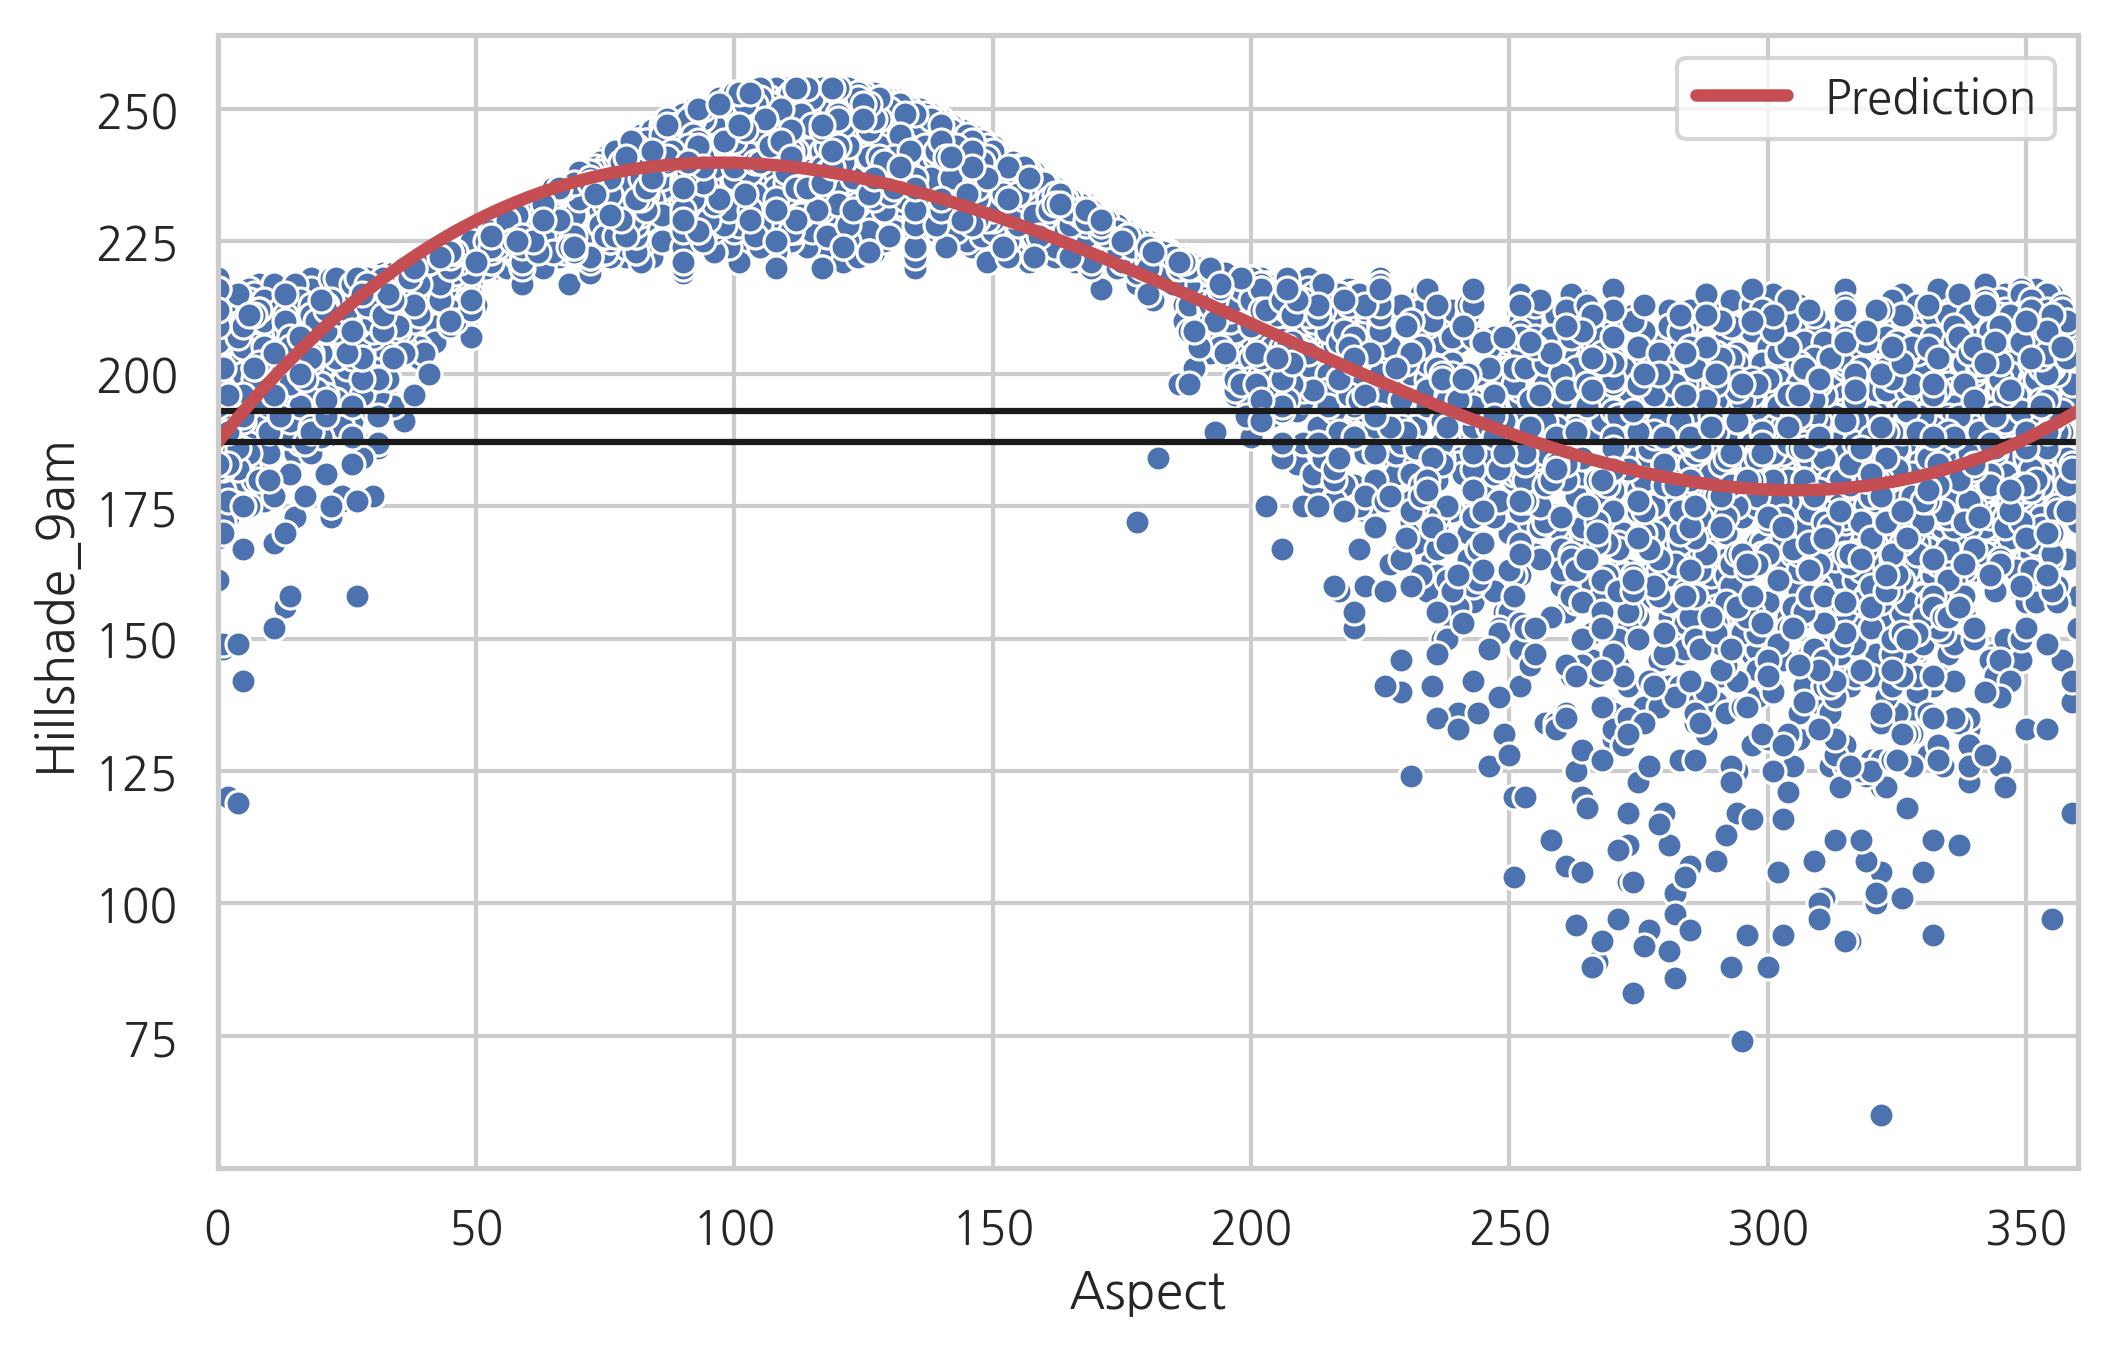

In [19]:
y_hat7 = result7.predict(df_covtype)
df7 = pd.concat([y_hat7, df_covtype.Aspect], axis=1).sort_values("Aspect")
df7.columns = ["Prediction", "Aspect"]
df7.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result7.values[0], 0, 360)
plt.hlines(df_result7.values[1], 0, 360)
plt.show()

이를 방지하기 위해 일반적으로 주기성을 띄는 독립변수는 다음처럼 두 개의 독립변수로 분리한다.

$$
x \;\; \rightarrow
\begin{cases}
x_1 = \cos\left(\frac{2\pi}{360}x\right) \\
x_2 = \sin\left(\frac{2\pi}{360}x\right) 
\end{cases}
$$

In [20]:
f = 2.0 * np.pi / 360

model8 = sm.OLS.from_formula("""
Hillshade_9am ~ 
np.cos(f * Aspect) +
np.sin(f * Aspect)
""", data=df_covtype
)
result8 = model8.fit()
print(result8.summary())

                            OLS Regression Results                            
Dep. Variable:          Hillshade_9am   R-squared:                       0.727
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                 1.334e+04
Date:                Mon, 17 Jun 2019   Prob (F-statistic):               0.00
Time:                        17:28:34   Log-Likelihood:                -40515.
No. Observations:               10000   AIC:                         8.104e+04
Df Residuals:                    9997   BIC:                         8.106e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            208.8444      0

이렇게 하면 독립변수의 특징을 유지하면서 모형이 주기성을 가지게 된다.

In [21]:
df_result8 = result8.predict(df_test)
df_result8

0    196.069868
1    196.069868
dtype: float64

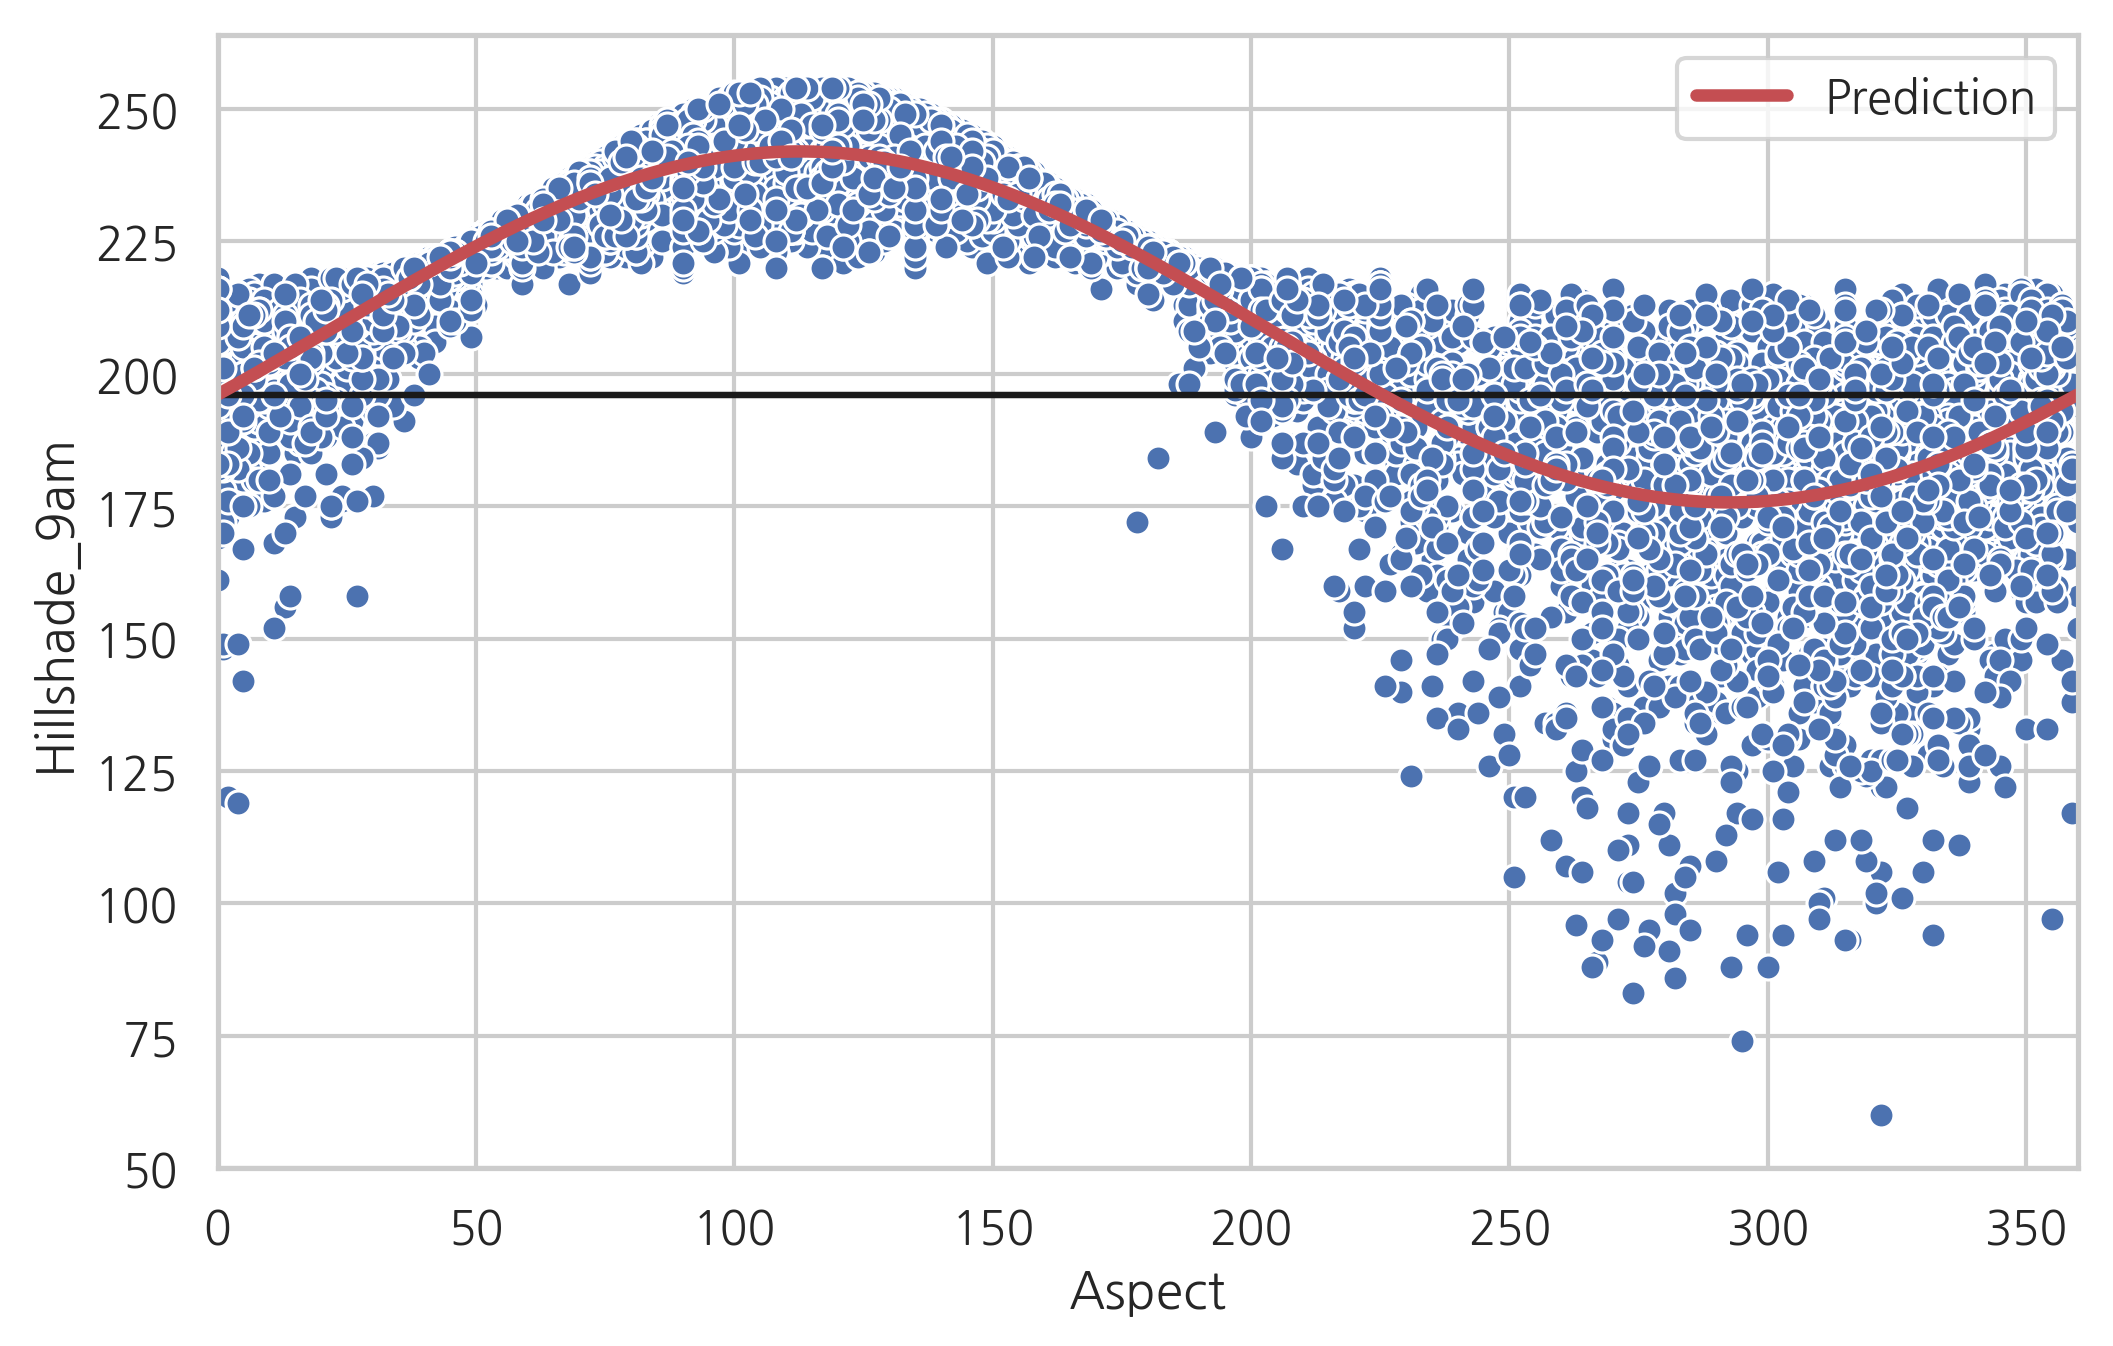

In [22]:
y_hat8 = result8.predict(df_covtype)
df8 = pd.concat([y_hat8, df_covtype.Aspect], axis=1).sort_values("Aspect")
df8.columns = ["Prediction", "Aspect"]
df8.plot(x="Aspect", style="r-", lw=3)
sns.scatterplot(x="Aspect", y="Hillshade_9am", data=df_covtype)
plt.hlines(df_result8.values[0], 0, 360)
plt.hlines(df_result8.values[1], 0, 360)
plt.show()

### 종속변수 변형

지금까지는 독립변수를 변형하는 방법을 사용했지만 경우에 따라서는 종속변수를 변형할 수도 있다. 예를 들어 LSTAT 독립변수로 보스턴 집값을 예측하는 선형회귀모형의 예측값과 실제값을 그리면 다음과 같다.

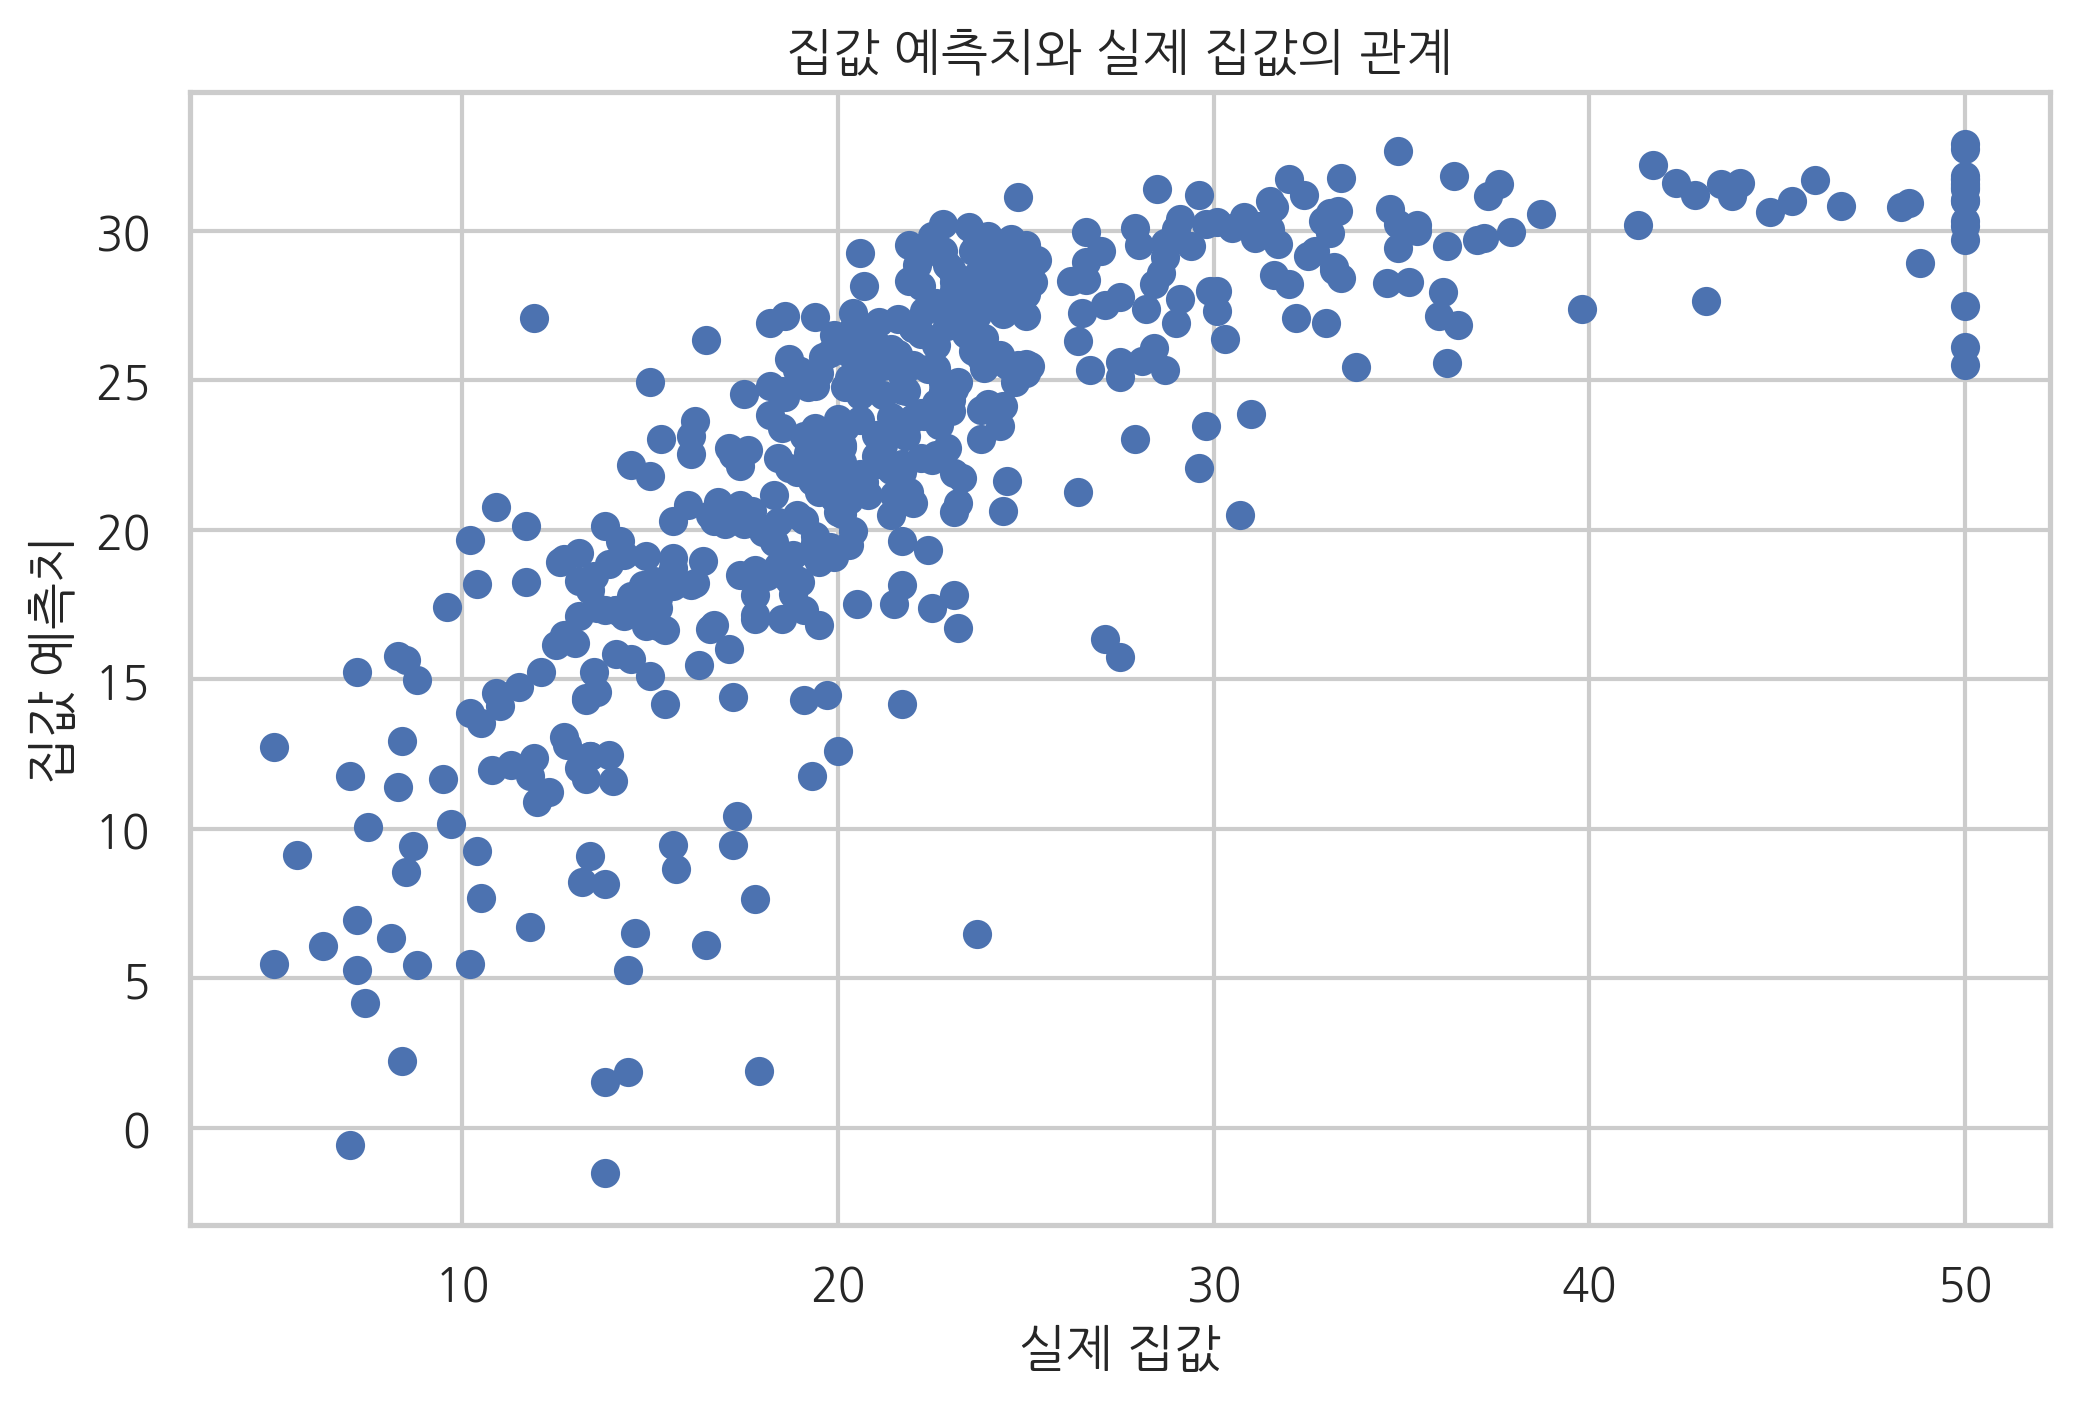

In [23]:
plt.scatter(boston.target, y_hat1)
plt.xlabel(u"실제 집값")
plt.ylabel(u"집값 예측치")
plt.title("집값 예측치와 실제 집값의 관계")
plt.show()

모형이 올바르다면 예측치와 실제 종속변수값을 그린 스캐터 플롯은 선형적인 모습이 나와야 한다. 하지만 실제로는 제곱근이나 로그 그래프와 더 유사하다. 이러한 경우에는 이 스캐터 플롯을 선형적으로 만들어 주도록 예측치를 비선형 변환한다. 여러가지 모형을 비교해보면 독립변수와 종속변수를 모두 로그 변환한 모형이 가장 좋다는 것을 알 수 있다.

In [24]:
model11 = sm.OLS.from_formula("np.sqrt(MEDV) ~ LSTAT", data=df_boston)
result11 = model11.fit()
print(result11.summary())

                            OLS Regression Results                            
Dep. Variable:          np.sqrt(MEDV)   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     789.7
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          3.09e-105
Time:                        17:28:35   Log-Likelihood:                -445.65
No. Observations:                 506   AIC:                             895.3
Df Residuals:                     504   BIC:                             903.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.9499      0.053    112.374      0.0

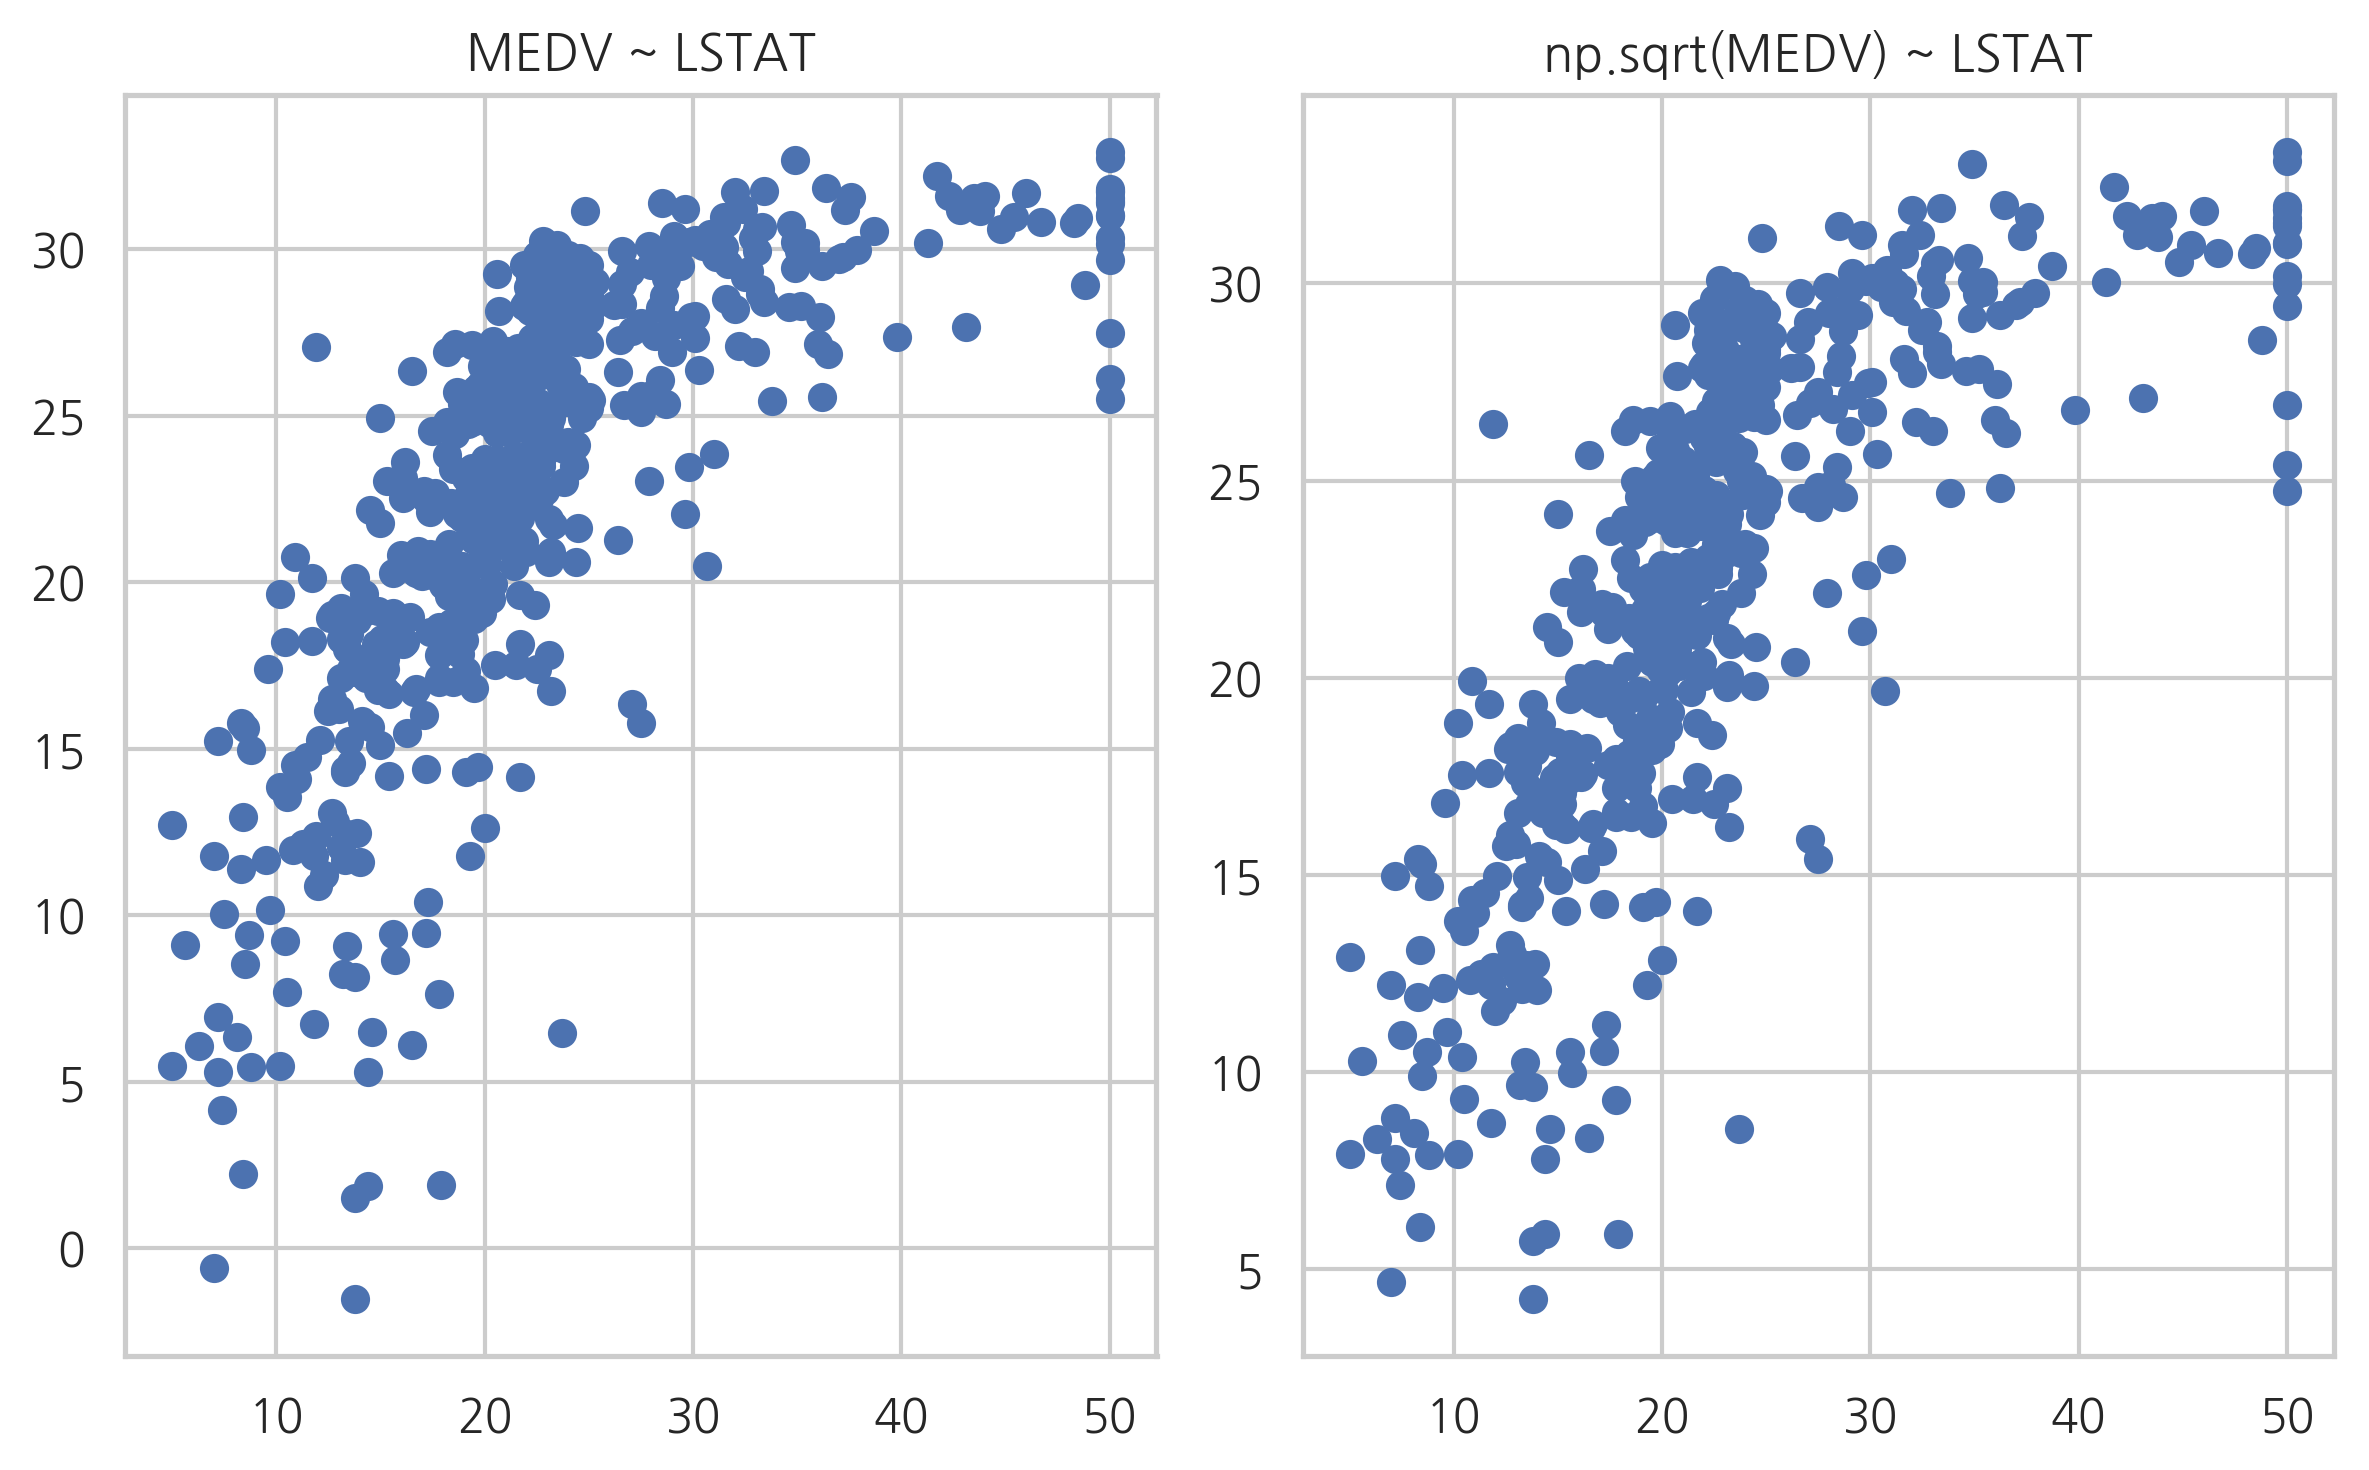

In [25]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, (result11.predict(df_boston))**2)
plt.title("np.sqrt(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [26]:
model12 = sm.OLS.from_formula("np.log(MEDV) ~ LSTAT", data=df_boston)
result12 = model12.fit()
print(result12.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.647
Method:                 Least Squares   F-statistic:                     928.1
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          2.23e-116
Time:                        17:28:35   Log-Likelihood:               -0.57634
No. Observations:                 506   AIC:                             5.153
Df Residuals:                     504   BIC:                             13.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6176      0.022    164.654      0.0

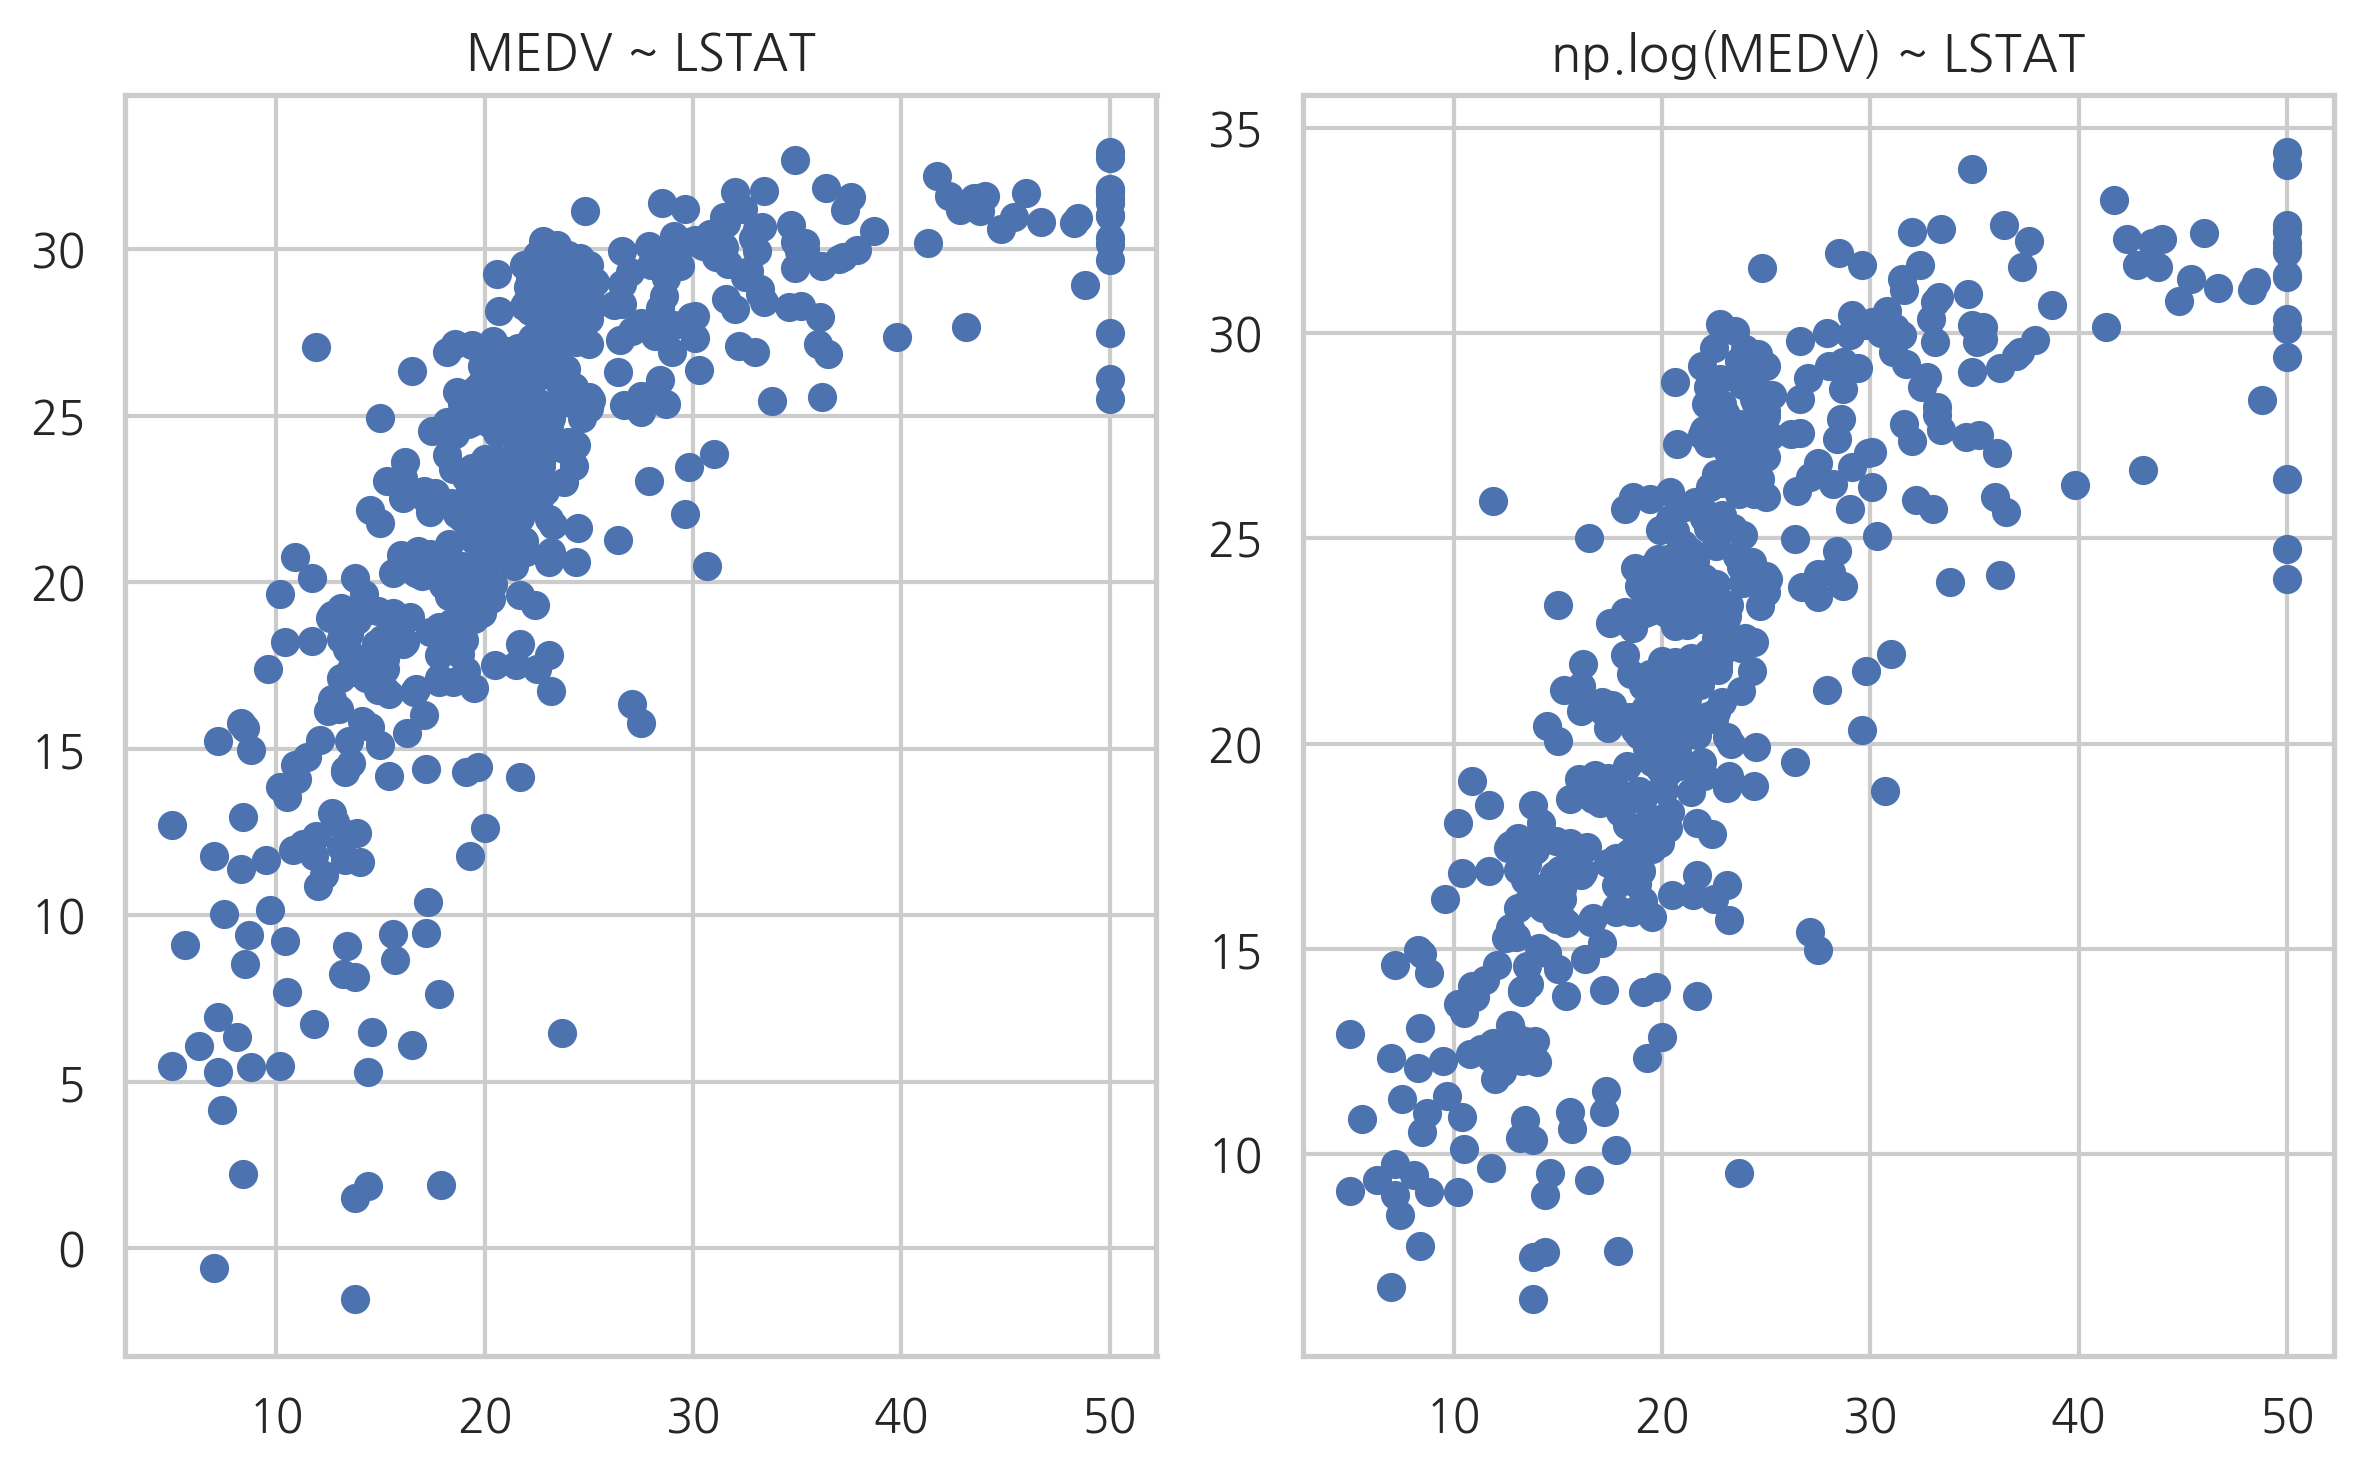

In [27]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result12.predict(df_boston)))
plt.title("np.log(MEDV) ~ LSTAT")
plt.tight_layout()
plt.show()

In [28]:
model13 = sm.OLS.from_formula("np.log(MEDV) ~ np.log(LSTAT)", data=df_boston)
result13 = model13.fit()
print(result13.summary())

                            OLS Regression Results                            
Dep. Variable:           np.log(MEDV)   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     1058.
Date:                Mon, 17 Jun 2019   Prob (F-statistic):          7.32e-126
Time:                        17:28:36   Log-Likelihood:                 21.325
No. Observations:                 506   AIC:                            -38.65
Df Residuals:                     504   BIC:                            -30.20
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.3618      0.042    103.603

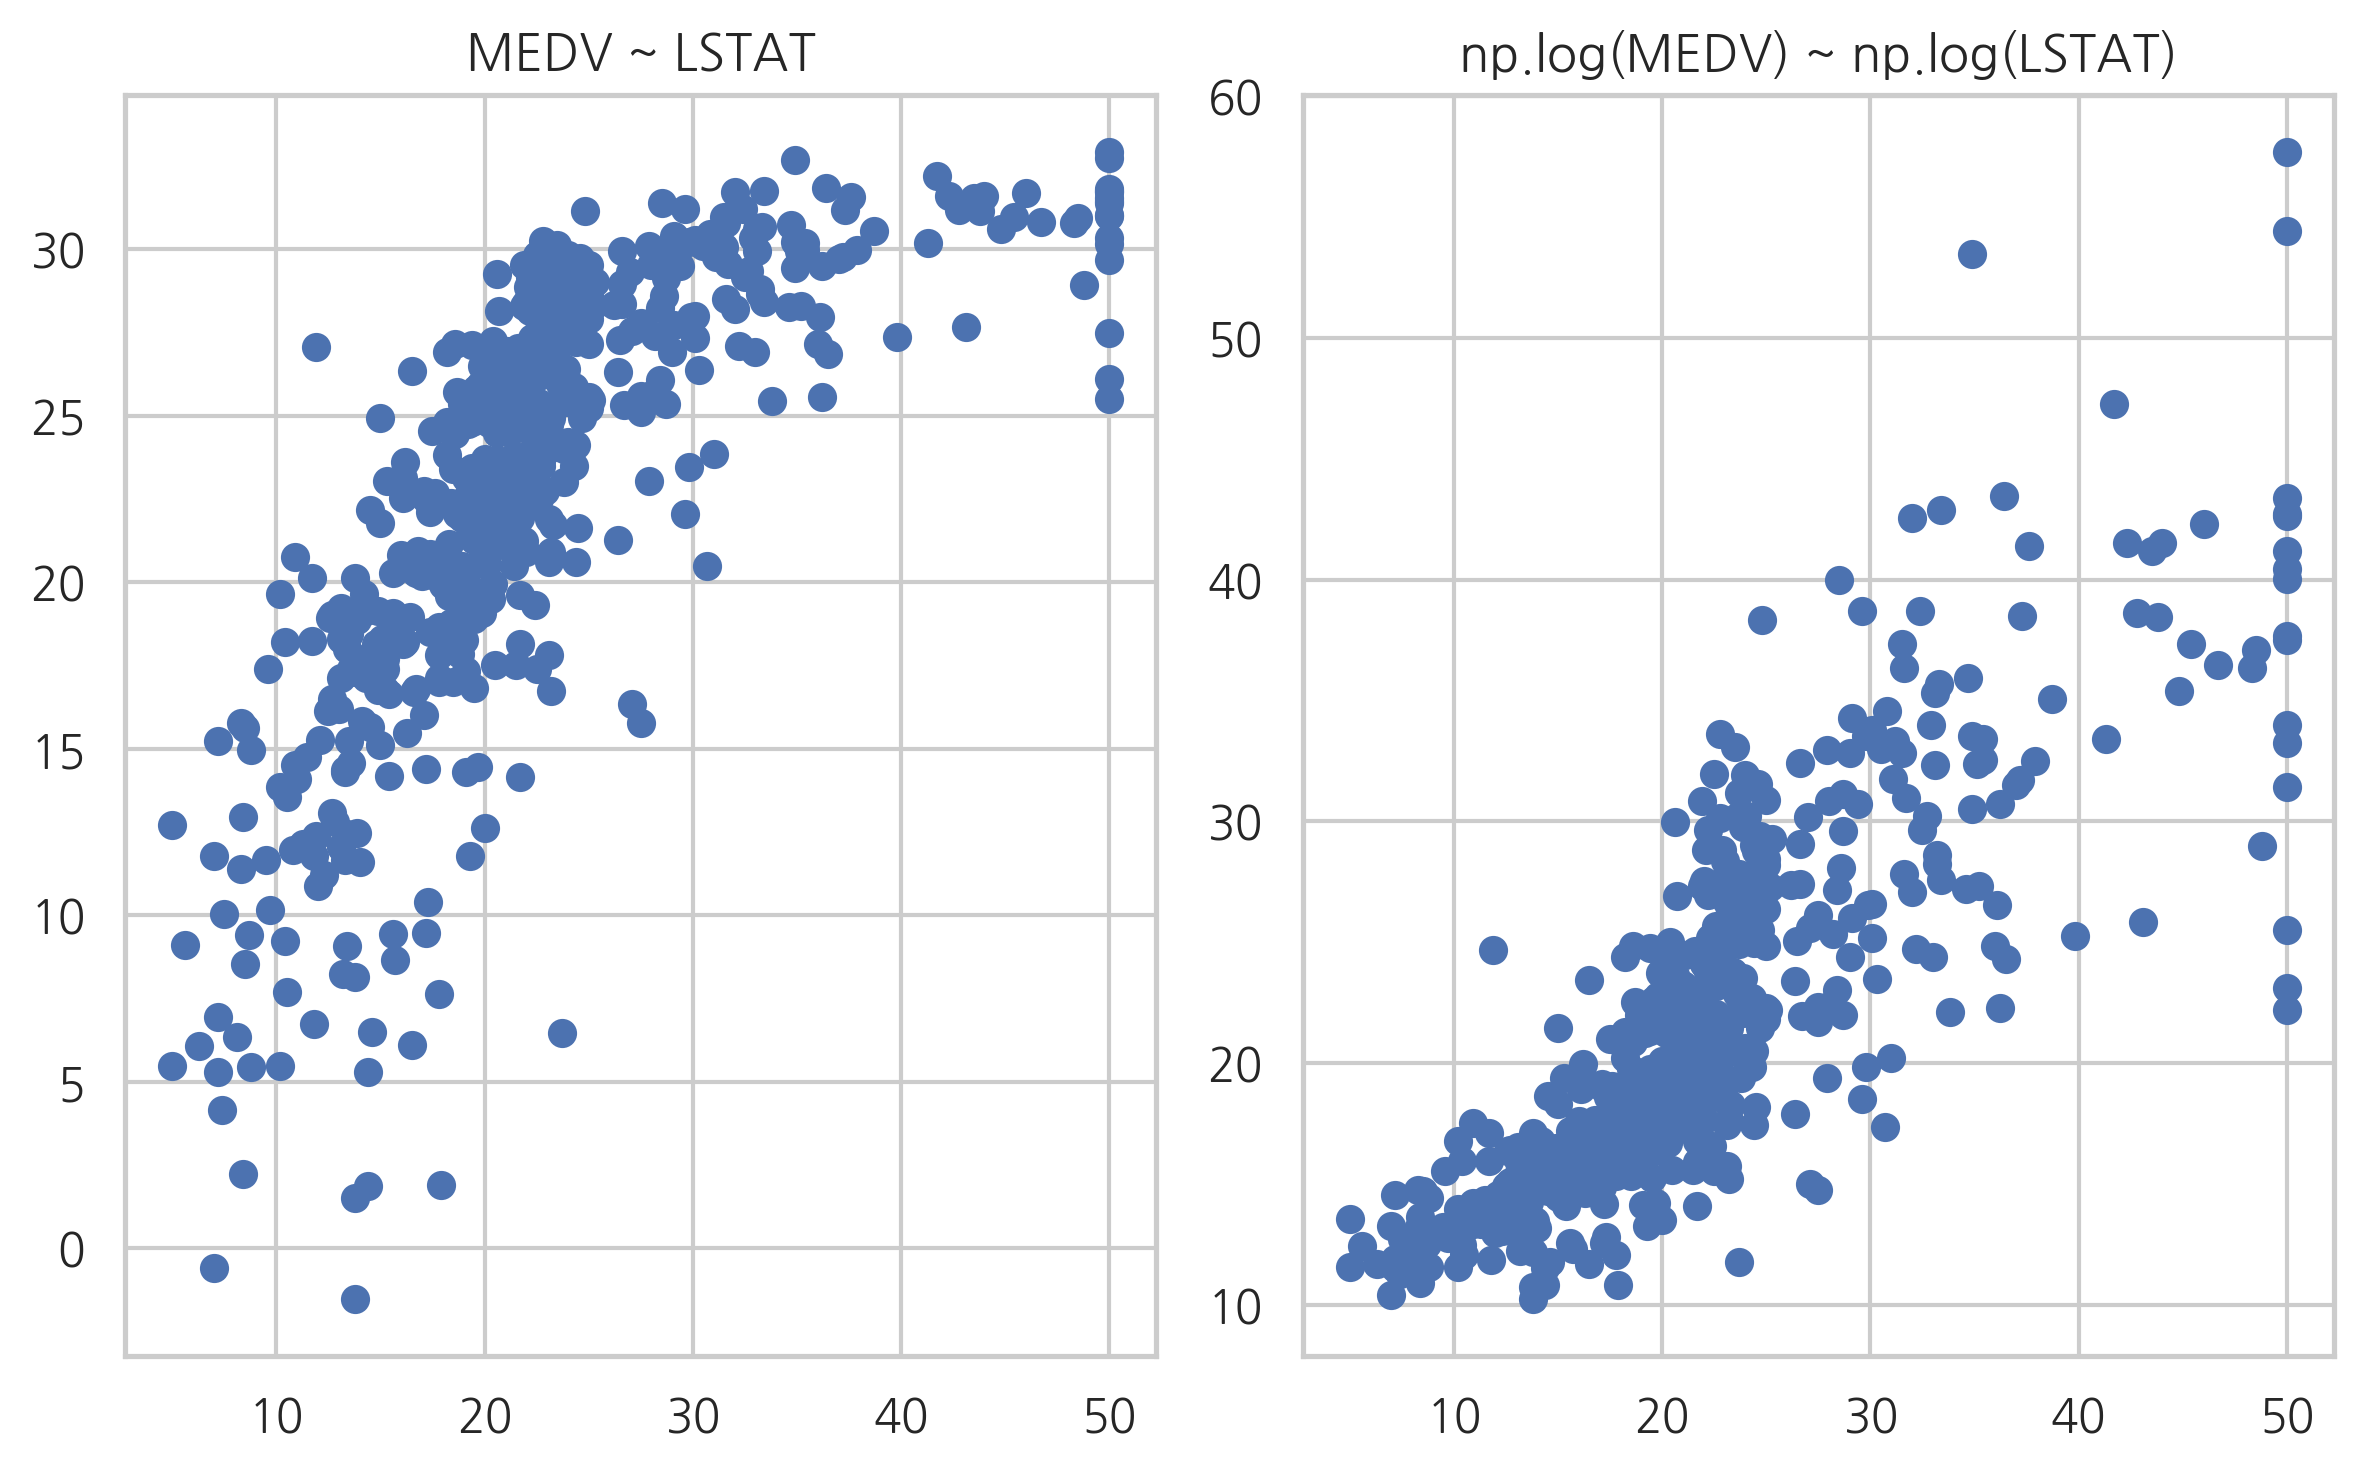

In [29]:
plt.subplot(121)
plt.scatter(boston.target, y_hat1)
plt.title("MEDV ~ LSTAT")
plt.subplot(122)
plt.scatter(boston.target, np.exp(result13.predict(df_boston)))
plt.title("np.log(MEDV) ~ np.log(LSTAT)")
plt.tight_layout()
plt.show()